# 0. Постановка задачи

Тема курсовой работы: "_Решение задачи сегментации деталей автомобиля при помощи современных методов машинного обучения_".\
Исходный датасет предоставлен Сергеем Вячеславовичем Макрушиным. В нем находятся фотографии машин и разметка деталей. В пояснительной записке к датасету говорится о том, что существует два вида разметки: максимум 10 деталей и 58 деталей. Было выбрано решать задачу именно для первого случая. Необходимо определить принадлежность пикселя к одному из классов

0. Background (Фон)
1. Roof (Крыша)
2. Front-windshield (Переднее лобовое стекло)
3. Face (Перед машины)
4. Left-window (Левое стекло)
5. Left-body (Левая часть машины)
6. Right-window (Правое окно)
7. Right-body (Правая часть машины)
8. Rear-windshield (Заднее лобовое стекло)
9. Rear (Задняя часть машины)

__Постановка задачи__: Задача сегментации объектов состоит в том, чтобы каждому пикселю изображения поставить в соответствие  номер класса объекта.

Решать данную задачу будем с помощью методов глубокого обучения. В этом нам поможет библиотека _Segmatation Models_. Возьмем 4 модели. Описание каждой модели будет представлено позднее. 

# 1.Библиотеки

In [30]:
import torch # структуры данных для многомерных тензоров и математические операции над этими тензорами
import torch.nn as nn # модуль для создания нейронных сетей (слои, функции ошибок и тд)
import torch.optim as optim # оптимизаторы и скедьюлеры
from torch.utils.data import Dataset, DataLoader, random_split # для создания своих датасетов и даталоадеров
from torchvision import transforms, io # предобработка изображений
import torch.nn.functional as F # функции для обработки изображений
from torchmetrics import Dice, JaccardIndex # метрики качества
import segmentation_models_pytorch as smp # модуль с моделями для сегментации с предобученными весами

# Библиотеки для обработки и визуализации данных
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

from PIL import Image # Библиотека для получения изображений


from tqdm.notebook import tqdm # визуализация с прогресс-барами
import os # для взаимодействия с системой
import time # для замеров времени
import csv # для создания csv файла с моделями

# 2. Обработка датасета

__2.1__  Переходим в папку на диске C, где лежит датасет

In [45]:
os.chdir(r"C:\Education\Financial_Academy\CourseWork\Cars-Segmentation") # изменяем текущую директория
print(f"Текущая директория\n{os.getcwd()}") # Проверка, что мы находимся в выбранной директории

Текущая директория
C:\Education\Financial_Academy\CourseWork\Cars-Segmentation


__2.2__   Создание списка номеров папок в датасете. В исходном датасет картинки лежат в 24 папках с названиями 1-24.

In [3]:
## данную ячейку запускать не нужно!
numbers = [str(i).zfill(2) for i in range(1, 24)]

__2.3__  Оказалось, что в части папок присутствуют папки, которые дублируют другие, однако в них ничего нет. При загрузке фотографий линейным проходом эти пустые папки могут заменить непустые, ссылки на которые уже были загружены. Для решения данной проблемы необходимо очистить папки от пустых.

In [8]:
## данную ячейку запускать не нужно!
# удаление пустых папок в каждой части архива
for numb in numbers:
    path = r'images.part{}\images'.format(numb) # путь к папке по номеру
    for root, dirs, files in os.walk(path, topdown=False): # проход по всем объектам папки
        for name in dirs: # проход по всем папка
            folder_path = os.path.join(root, name)
            if not os.listdir(folder_path): # проверка на то, что директория пустая
                os.rmdir(folder_path) # удаление пустой директории

__2.4__ Объединение файлов в одну папку и перименование каждого файла в dirname_filename.jpg. Делаем это с целью составить удобное соотвествие между размеченными фотографиями и входными, так как именно в таком формате данные записаны в `coarse_index_list.txt`

In [10]:
## данную ячейку запускать не нужно!
target_folder = 'train_images' # папка, куда будут идти переименованные изображения
for numb in numbers:
    source_folder = r'images.part{}\images'.format(numb) # папка, где лежать изображения
    
    # Список папок
    folders = [f for f in os.listdir(source_folder) if os.path.isdir(os.path.join(source_folder, f))]
    
    for folder_name in folders:
        files = [f for f in os.listdir(os.path.join(source_folder, folder_name))] # список фотографий
        
        for file in files:
            path = "\\".join([folder_name, file]).replace("\\", "_") # соединим название папки И файла
            source_path = os.path.join(source_folder, folder_name, file) # путь до картинки
            target_path = os.path.join(target_folder, path) # путь до папки, куда хотим переместить
            # Запускал программу несколько раз, не доводя до конца, поэтому некоторые изображения были обработаны
            # Для корректной работы программы необходима обработать данные исключения
            try:
                os.rename(source_path, target_path) # перемещение
            except FileExistsError:
                continue
            except FileNotFoundError:
                continue

__2.5__ В файле `coarse_index_list.txt` в каждой строке описано соотвествие неразмченной фотографии с разметкой. В своей работе я решал задачу сегментации для максимум: 10 классов деталей. Данное решение обусловено мощностью компьютера. Необходимо создать датафрейм, где строка будет представлять название фото из разметки и входной фотографии. 

_Замечание_: Для названий фотографий из разметки, где длина названия меньше пяти символов в файле `coarse_index_list.txt` записано неверное название. Не хватает _0_ в начале. Функция _f_ решает как раз эту задачу.

In [46]:
# Считываем датасет, как pandas.DataFrame
S = pd.read_csv("MVP_v1.0\coarse_index_list.txt", header=None)[0]

# Кодовое слово для файла для входных данных моей задачи
mask = S.apply(lambda x: "veriwild" in x) 

# Разбиваем на 2 названия
razm_not = S[mask].str.split(" veriwild ", expand=True).rename(columns = {0 : "Разметка",
                                                                          1 : "Тренировка"})
def f(x):
    """Функция, которая добавляет 0 в начало названия, которое содержит меньше 5 символов"""
    if len(x) <= 4:
        return "0" + x + ".png"
    else:
        return x + ".png"

# Применяем нашу функцию  
razm_not["Разметка"] = razm_not["Разметка"].apply(f)
razm_not

Разметка        Тренировка
438    00440.png  03822_039153.jpg
439    00441.png  03826_039181.jpg
440    00442.png  03827_039201.jpg
441    00443.png  03830_039211.jpg
442    00444.png  03830_039221.jpg
...          ...               ...
19983  20007.png  40657_416222.jpg
19984  20008.png  40659_416232.jpg
19985  20009.png  40663_416258.jpg
19986  20010.png  40667_416278.jpg
19987  20011.png  40670_416308.jpg

[18028 rows x 2 columns]

Видим, что для обучения модели нам доступна выборка в __18028__ элементов. Этого количества вполне хватит для решения поставленной задачи.

__2.6__ В датасете содержится куда больше фотографий, чем необходимо нам для решения поставленной задачи. Удалим оставшиеся, чтобы не держать ненужные файлы в памяти компьютера.

In [16]:
## данную ячейку запускать не нужно!
folder_path = "train_images" # путь к рабочей папке
files = os.listdir(folder_path) # файлы в ней

for file_name in tqdm(files):
    if file_name in train_imgs: 
        continue
    else: # если элемент не входит в датафрейм, то удаляем его из памятию
        file_path = os.path.join(folder_path, file_name)
        os.remove(file_path)

100%|█████████████████████████████████████████████████████████████████████████| 416314/416314 [17:03<00:00, 406.72it/s]


# 3. Создание датасета в Pytorch

__3.1__ Создадим датасет с нашими машинами. Подробно опишем этапы создания датасета:
* Разобьем наш датасет на тренировочный и тестовый (тестовый не будем использовать для обучения).
* В качестве данных будем хранить ссылки на неразмеченные и размеченные фотографии и списки с названиями.
* Приведем картинки к форме: 256 на 256.
* Переведем неразмеченные и размеченные фотографии в тензоры размера (3, 256, 256), так как изображения цветные.
* Переведем в тип данных float.
* Проведем отдельную манипуляцию с размеченными фотографиями.
1. Переведем трехканальные изоражения в одноканальные с помощью линейного биективного отображения по следующей формуле:
<h1><center>$3\times R^{256}\times R^{256}\rightarrow R^{256}\times R^{256} :MASK = (R, G, B) \cdot(1, 256, 256^2)$</center></h1>
2. Переведем полученные уникальные числа в цифры от 0 до 9, соотвествующие номеру класса.
3. Применив данное преобразование (reformat_mask) получим одноканальное изображение, где интенсивность пикселя соотвествует номеру класса детали.
* Для представления фотографии проведем обратное преобразование: номеру класса будет присвоен тензор длины 3 с цветом этого класса в RGB.

In [47]:
# Датасет для обучения, где будет содержаться первые 15000 фотографий
class MVP_train_dataset(Dataset):
    """Тренировочный датасет с машинами"""
    def __init__(self, transform=None, transform_labels=None):
        self.path_x = "train_images" # путь к входным значениям
        self.path_y = "MVP_v1.0/coarse_visualization_RGB" # путь к размеченным фотографиям
        self.x_data = razm_not["Тренировка"].values[:15000] # 15000 картинок для обучения
        self.y_data = razm_not["Разметка"].values[:15000] # 15000 размеченных картинок (ответов) для обучения
        self.n_samples = self.x_data.shape[0] # количество элементов в тренировочнйо выборке
        self.transform = transform # трансформеры (предобработка) входных картинок
        self.transform_label = transform_labels # трансформеры (предобработка) ответов
        
    def __getitem__(self, index):
        """Получение элемента датасета по индексу"""
        sample = '/'.join([self.path_x, self.x_data[index]]), '/'.join([self.path_y, self.y_data[index]])
        
        if self.transform:
            img = Image.open(sample[0])
            label = Image.open(sample[1])
            img = self.transform(img) # применение трансформера к входным данным
            label = self.transform_label(label) # применение трансформера к размеченным данным
        return img, label.long()
    
    
    def show_img(self, index):
        """Метод, показывающий фотографии до входа и разметки"""
        im1, im2 = self[index] # inputs, label
        
        fig, axs = plt.subplots(1, 2, figsize = (10, 10))
        axs[0].imshow(im1.permute(1,2,0)) # фотография фотографии на вход
        axs[1].imshow(grayscale_to_RGB(im2).permute(1,2,0)) # трехканальное изображение размеченной фотографии
        axs[0].set_label('Входные данные') # подпись к левому графику
        axs[1].set_label('Разметка') # подпись к правому графику
        return fig, axs
        
        
    def __len__(self):
        """Метод, возвращающий число элементов в выборке"""
        return self.n_samples

    
# Отложенная выборка для тестирования модели    
class MVP_test_dataset(Dataset):
    """Датасет с машинами"""
    def __init__(self, transform=None, transform_labels=None):
        self.path_x = "train_images" # путь к входным значениям
        self.path_y = "MVP_v1.0/coarse_visualization_RGB" # путь к размеченным фотографиям
        self.x_data = razm_not["Тренировка"].values[15000:len(razm_not["Тренировка"].values)] # входные данные
        self.y_data = razm_not["Разметка"].values[15000:len(razm_not["Разметка"].values)] # ответы
        self.n_samples = self.x_data.shape[0] # количество экземпляров в тестовой выборке
        self.transform = transform # трансформеры (предобработка) входных картинок
        self.transform_label = transform_labels # трансформеры (предобработка) ответов
        
    def __getitem__(self, index):
        """Получение элемента датасета по индексу"""
        sample = '/'.join([self.path_x, self.x_data[index]]), '/'.join([self.path_y, self.y_data[index]])
        
        if self.transform:
            img = Image.open(sample[0])
            label = Image.open(sample[1])
            img = self.transform(img) # применение трансформера к входным данным
            label = self.transform_label(label) # применение трансформера к размеченным данным
        return img, label.long()
    
    
    def show_img(self, index):
        """Метод, показывающий фотографии до входа и разметки"""
        im1, im2 = self[index]
        
        fig, axs = plt.subplots(1, 2, figsize = (10, 10))
        axs[0].imshow(im1.permute(1,2,0)) # фотография на вход
        axs[1].imshow(grayscale_to_RGB(im2).permute(1,2,0)) # разметка
        axs[0].set_label('Входные данные') # подпись к левому графику
        axs[1].set_label('Разметка') # подпись к правому графику
        return fig, axs
        
        
    def __len__(self):
        """Метод, возвращающий длину датасета"""
        return self.n_samples
    
# Линейное преобразование, переводящее трехмерный тензор в матрицу, является биекцией  
lin_func = torch.tensor([1, 256., 256.**2])


# Перевод полученных чисел в числа от 0 до 9 для удобства
decoder_dict = {
    torch.dot(lin_func, torch.tensor([0, 0, 0], dtype=torch.float32)/255).item() : 0,
    torch.dot(lin_func, torch.tensor([127, 127, 255], dtype=torch.float32)/255).item() : 1,
    torch.dot(lin_func, torch.tensor([255, 255, 127], dtype=torch.float32)/255).item() : 2,
    torch.dot(lin_func, torch.tensor([212, 212, 212], dtype=torch.float32)/255).item() : 3,
    torch.dot(lin_func, torch.tensor([127, 255, 255], dtype=torch.float32)/255).item() : 4,
    torch.dot(lin_func, torch.tensor([255, 212, 127], dtype=torch.float32)/255).item() : 5,
    torch.dot(lin_func, torch.tensor([212, 127, 127], dtype=torch.float32)/255).item() : 6,
    torch.dot(lin_func, torch.tensor([127, 212, 255], dtype=torch.float32)/255).item() : 7,
    torch.dot(lin_func, torch.tensor([127, 255, 212], dtype=torch.float32)/255).item() : 8,
    torch.dot(lin_func, torch.tensor([212, 127, 212], dtype=torch.float32)/255).item() : 9
}


def decoder(inputs):
    """Функция, кодирующая фотографию в матрицу классов"""
    return decoder_dict[inputs]

# Описание классов    
CLASSES = {
    0 : ["background", torch.tensor([0, 0, 0], dtype=torch.int32)],
    1 : ["Roof", torch.tensor([127, 127, 255], dtype=torch.int32)],
    2 : ["Front-windshield", torch.tensor([255, 255, 127], dtype=torch.int32)],
    3 : ["Face", torch.tensor([212, 212, 212], dtype=torch.int32)],
    4 : ["Left-window", torch.tensor([127, 255, 255], dtype=torch.int32)],
    5 : ["Left-body", torch.tensor([255, 212, 127], dtype=torch.int32)],
    6 : ["Right-window", torch.tensor([212, 127, 127], dtype=torch.int32)],
    7 : ["Right-body", torch.tensor([127, 212, 255], dtype=torch.int32)],
    8 : ["Rear-windshield", torch.tensor([127, 255, 212], dtype=torch.int32)],
    9 : ["Rear", torch.tensor([212, 127, 212], dtype=torch.int32)]
}  


def class_to_color(el):
    """Перевод класса в трехканальное изображение"""
    return CLASSES[el][1]


def grayscale_to_RGB(img):
    """Обратный перевод из одно- в трехканальное изображение"""
    result = torch.zeros((3, 256, 256)).to(torch.int32)
    for i in range(256):
        for j in range(256):
            result[:,i,j] = class_to_color(img[i, j].item())
    return result
    
    

def encoder(tens):
    """Кодировщик трехканального тензора в матрицу"""
    R, G, B = tens[0], tens[1], tens[2]
    return R + G * 256 + B * 256**2

 
class reformat_mask(object):
    """Трансформер, обеспечивающий перевод в одноканальную маску"""
    def __call__(self, label):
        enc_label = encoder(label)
        label = enc_label.apply_(decoder)
        return label
    
    
inputs_trfms = transforms.Compose([
         transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.NEAREST),# измнение размера картинки
         transforms.PILToTensor(), # перевод картинки в тензор размера (3, 256, 256)
         transforms.ConvertImageDtype(torch.float) # измнение типа дыннх
 ])  
labels_trfms = transforms.Compose([
         transforms.Resize(size=(256, 256), interpolation=transforms.InterpolationMode.NEAREST),# измнение размера картинки
         transforms.PILToTensor(),# перевод картинки в тензор размера (3, 256, 256)
         transforms.ConvertImageDtype(torch.float), # измнение типа дыннх
         reformat_mask() # измнение маски в одноканальную, где цвет- номер класса
 ])  

train_dataset_to_val = MVP_train_dataset(transform=inputs_trfms, transform_labels=labels_trfms)
test_dataset = MVP_test_dataset(transform=inputs_trfms, transform_labels=labels_trfms)
print(f"Количество элементов в обучающей выборке: {len(train_dataset_to_val)}")
print(f"Количество элементов в отложенной (тестовой) выборке: {len(test_dataset)}")

Количество элементов в обучающей выборке: 15000
Количество элементов в отложенной (тестовой) выборке: 3028


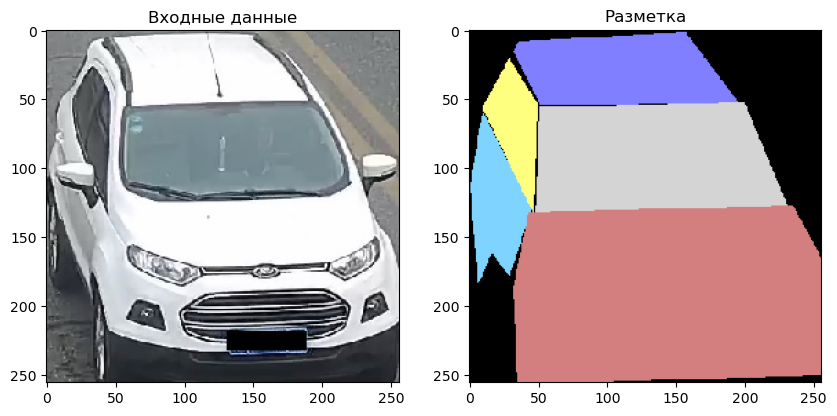

In [67]:
# Пример данных в датасете
fig, axs  = train_dataset_to_val.show_img(1)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
plt.show()

__3.2__ Создадим валидационный датасет для проверки обучения (диагностика переобучения). Так же он нужен для построения кривых обучения. Дело в том, что валидационный датасет создавался большое количество раз, поэтому модели обучались на разных тренировочных и валидационных датасетах. Можно сказать, что была непреднамеренно проведена квази-кросс-валидация. Однако метрики качества мы получали только на отложенной выборке, поэтому периодическое смешивание тренирочоного и валидационного датасета не влияло на показатели качества моделей.

In [48]:
val_ratio = 0.2
train_dataset, val_dataset = random_split(
    dataset=train_dataset_to_val, 
    lengths=[1-val_ratio, val_ratio],
)
print(f"Количество элементов в обучающей выборке: {len(train_dataset)}")
print(f"Количество элементов в валидационной выборке: {len(val_dataset)}")

Количество элементов в обучающей выборке: 12000
Количество элементов в валидационной выборке: 3000


__3.3__ Зададим рамзер батча для обучения, валидации и тренировки. Создадим 
* Тренировочный лоадер
* Валидационный лоадер
* Тестовый лоадер

In [49]:
batch_size_train = 10 # размер батча для обучения
batch_size_test = 1 # размер батча для валидации и тестирования модели
train_loader = DataLoader(train_dataset, batch_size=batch_size_train, shuffle=True) # тренировочный
valid_loader = DataLoader(val_dataset, batch_size=batch_size_test) # для валидации
test_loader = DataLoader(test_dataset, batch_size=batch_size_test) # тестовый

__3.4__ Зададим функции, котороые будем использовать для обучения и сохранения результатов.

In [50]:
def train(model, loader, loss_function, optimizer, scheduler=None):
    """
    Функция train() используется для обучения модели.
    Мы проходим циклом по всем объектам dataloader, получаем выходное значение модели,
    считаем функцию потерь, градиент и обновляем веса. 
    Возвращает среднее значение функции потерь на единицу.
    """
    model.train() # перевод nn.Module в режим обучения

    epoch_loss = 0 # изначально функция потерь равна нулю

    for inputs, labels in tqdm(loader): # цикл для прохода по всем элементам выборки
        inputs, labels = inputs.to(DEVICE), labels.to(DEVICE) # переводим на GPU
        
        outputs = model(inputs) # выход модели
        
        loss = loss_function(outputs, labels) # расчет функции потерь

        optimizer.zero_grad() # Устанавливает градиенты для слоев равными нулю.
        loss.backward() # Вычисляем градиенты функции потерь по параметрам модели
        optimizer.step() # Обновляет веса
        
        epoch_loss += loss.item() # Значение функции потерь на данной эпохе
        
    if scheduler is not None: # ход шедулера для изменения скорости обучения
        scheduler.step()
        
    return epoch_loss / len(loader) # функция возвращает loss на единицу

In [51]:
def test(model, loader, loss_function):
    """
    Функция проводит тестирование модели (для валидационной и тестовой выборок)
    Аналогично проходим по всему даталоадеру, выполняем расчет функции потерь, получаем ответ в виде
    одноканальной маски, считаем метрики качества модели. Возвращает среднее значение функции потерь, 
    метрику Dice, метрику Jaccard.
    """
    with torch.no_grad(): # отключение вычисления градиента
        model.eval() # перевод модели в режим работы
        N = 0
        total_loss = 0.0
        criterion1 = Dice(task="multiclass", num_classes=10) # метрика Dice
        criterion2 = JaccardIndex(task="multiclass", num_classes=10) # метрика Жаккарда 
        y_pred = [] # спсиок предсказаний модели
        y_true = [] # список ответов
        
        for i, (inputs, targets) in tqdm(enumerate(loader)):
            inputs, targets = inputs.to(DEVICE), targets.to(DEVICE) # данные на GPU
            outputs =  model(inputs) # Выход модели
            N += inputs.shape[0] # обновляем количество прошедших элементов
            loss = loss_function(outputs, targets) # расчет значения функции потерь
            total_loss += inputs.shape[0] * loss.item() # обновляем значение функции потерь
            y_pred.append(torch.argmax(outputs, dim=1).cpu()) # Получаем маску и переводим на CPU, иначе память кончится
            y_true.append(targets.cpu())
            
        targets = torch.concatenate(y_true) # соеднияем все в один torch.Tensor
        prediction = torch.concatenate(y_pred) # соеднияем все в один torch.Tensor
            
        return total_loss / N, criterion1(prediction, targets), criterion2(prediction, targets) # LOSS, DICE, JACCARD

In [52]:
def train_and_save_model(model, num_epochs, criterion, optimizer, scheduler, model_name):
    """
    Функция, обеспечивающая обучение модели и сохраняющая результаты в csv файл. Для каждой эпохи в цикле
    происходит вызов функции train(), затем для диагностики переобучения вызыввается функция test() для валидационного 
    даталоадера. Функция через print() выводит результаты для каждой эпохи. После окончания обучения модель выводит кривую
    обучения для тренировочной и валидационной выборки, сохраняя ее в файл с уникальным названием.
    Затем выполняем расчет показателей на тестовой выборке и сохраняем их в csv файл с моделями.
    В конце сохраняем модель.
    """ 
    start_time = time.time() # засекаем начало отсчета
    
    DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
    model.to(DEVICE) # перевод модели на GPU
    
    
    train_losses = [] # список потерь на обучении
    val_losses = [] # список потерь на валидаци
    
    
    for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе 
        # обучение
        train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
        # валидация
        val_loss, DICE, JACCARD = test(model=model, loader=valid_loader, loss_function=criterion)
        
        train_losses.append(train_loss) # сохраняем ошибку на обучени
        val_losses.append(val_loss) # сохраняем ошибку на валидации
        # вывод номера эпохи, ошибки и метрик качества
        print(f'Epoch {epoch + 1}')
        print(f'Train Loss {train_loss:.6f} Val loss {val_loss:.6f} Dice {DICE:.6f} JaccardIndex {JACCARD:.6f}')
        print('---')
        
        
    end_time = time.time() - start_time # время окончания обучения
    
    # Вывод графика
    fig, ax = plt.subplots()
    ax.set_title("Функция потерь на тренировочной и валидационной выборках")
    ax.plot(range(1, num_epochs + 1), np.array(train_losses), label = 'Ошибка на обучении')
    ax.plot(range(1, num_epochs + 1), np.array(val_losses), label = 'Ошибка на валидации')
    ax.legend()
    ax.grid()
    ax.set(xlabel = 'Эпоха', ylabel = 'CEL')
    plt.show()
    fig.savefig('SEGMENTATION_MODELS/{}.png'.format(model_name)) # сохранение графика
    
    
    loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion) # тестирование на отложенной выборке
    
    
    with open('models_scores.csv', mode='a', encoding='utf-8') as f: # запись резльтатов в csv файл
        file_writer = csv.writer(f, delimiter=',', lineterminator="\r")
        file_writer.writerow([model_name, num_epochs, loss, dic.item(), jacc.item(), end_time])
        
    torch.save(model.state_dict(), r"SEGMENTATION_MODELS/{}.pth".format(model_name)) # сохранение модели
        
    return model_name, num_epochs, loss, dic, jacc, end_time

__3.5__ Создадим заголовок csv-файла, куда будем сохранять модели

In [ ]:
## данную ячейку запускать не нужно!
with open('models_scores.csv', mode='w', encoding='utf-8') as f:
    filewriter = csv.writer(f)
    filewriter.writerow(['model_name','num_epochs', 'loss', 'Dice', 'Jaccard', 'Time']) # заголовки

# 4. Обучение моделей

In [53]:
os.environ["PYTORCH_CUDA_ALLOC_CONF"] = "max_split_size_mb:1024" # установка максимального reserved memory на GPU

__N.B.__ К сожалению, прогресс бары пропадают при закрытии ноутбука. 50 часов для нового обучения у меня нет физически, поэтому они отсутствуют.

# 4.1 Модель Unet++ 
Unet++ является полносвязной сверточной нейронной сетью для семантической сегментации изображений. Содержит энкодер и декодер, соединенные skip-connections. Последние объединяют глубокие, семантические, грубые карты признаков из подсети декодера с неглубокими, низкоуровневыми картами признаков из декодера. Слои энкодера представляют собой сверточные слои с предобученными весами модели ResNet. Данная архитектура позволяет сократить семантический разрыв между картами признаков подсетей энкодера и декодера, потому что сверточные слои позволяют сделать "мост" между каждым слоем энкодера и декодера, следовательно, теряется меньше информации. На рисунке можно видеть архитектуру данной нейронной сети. Выходом модели является тензор формой (1, C, H, W), где
* С- число классов
* H- высота картинки
* W- ширина картинки

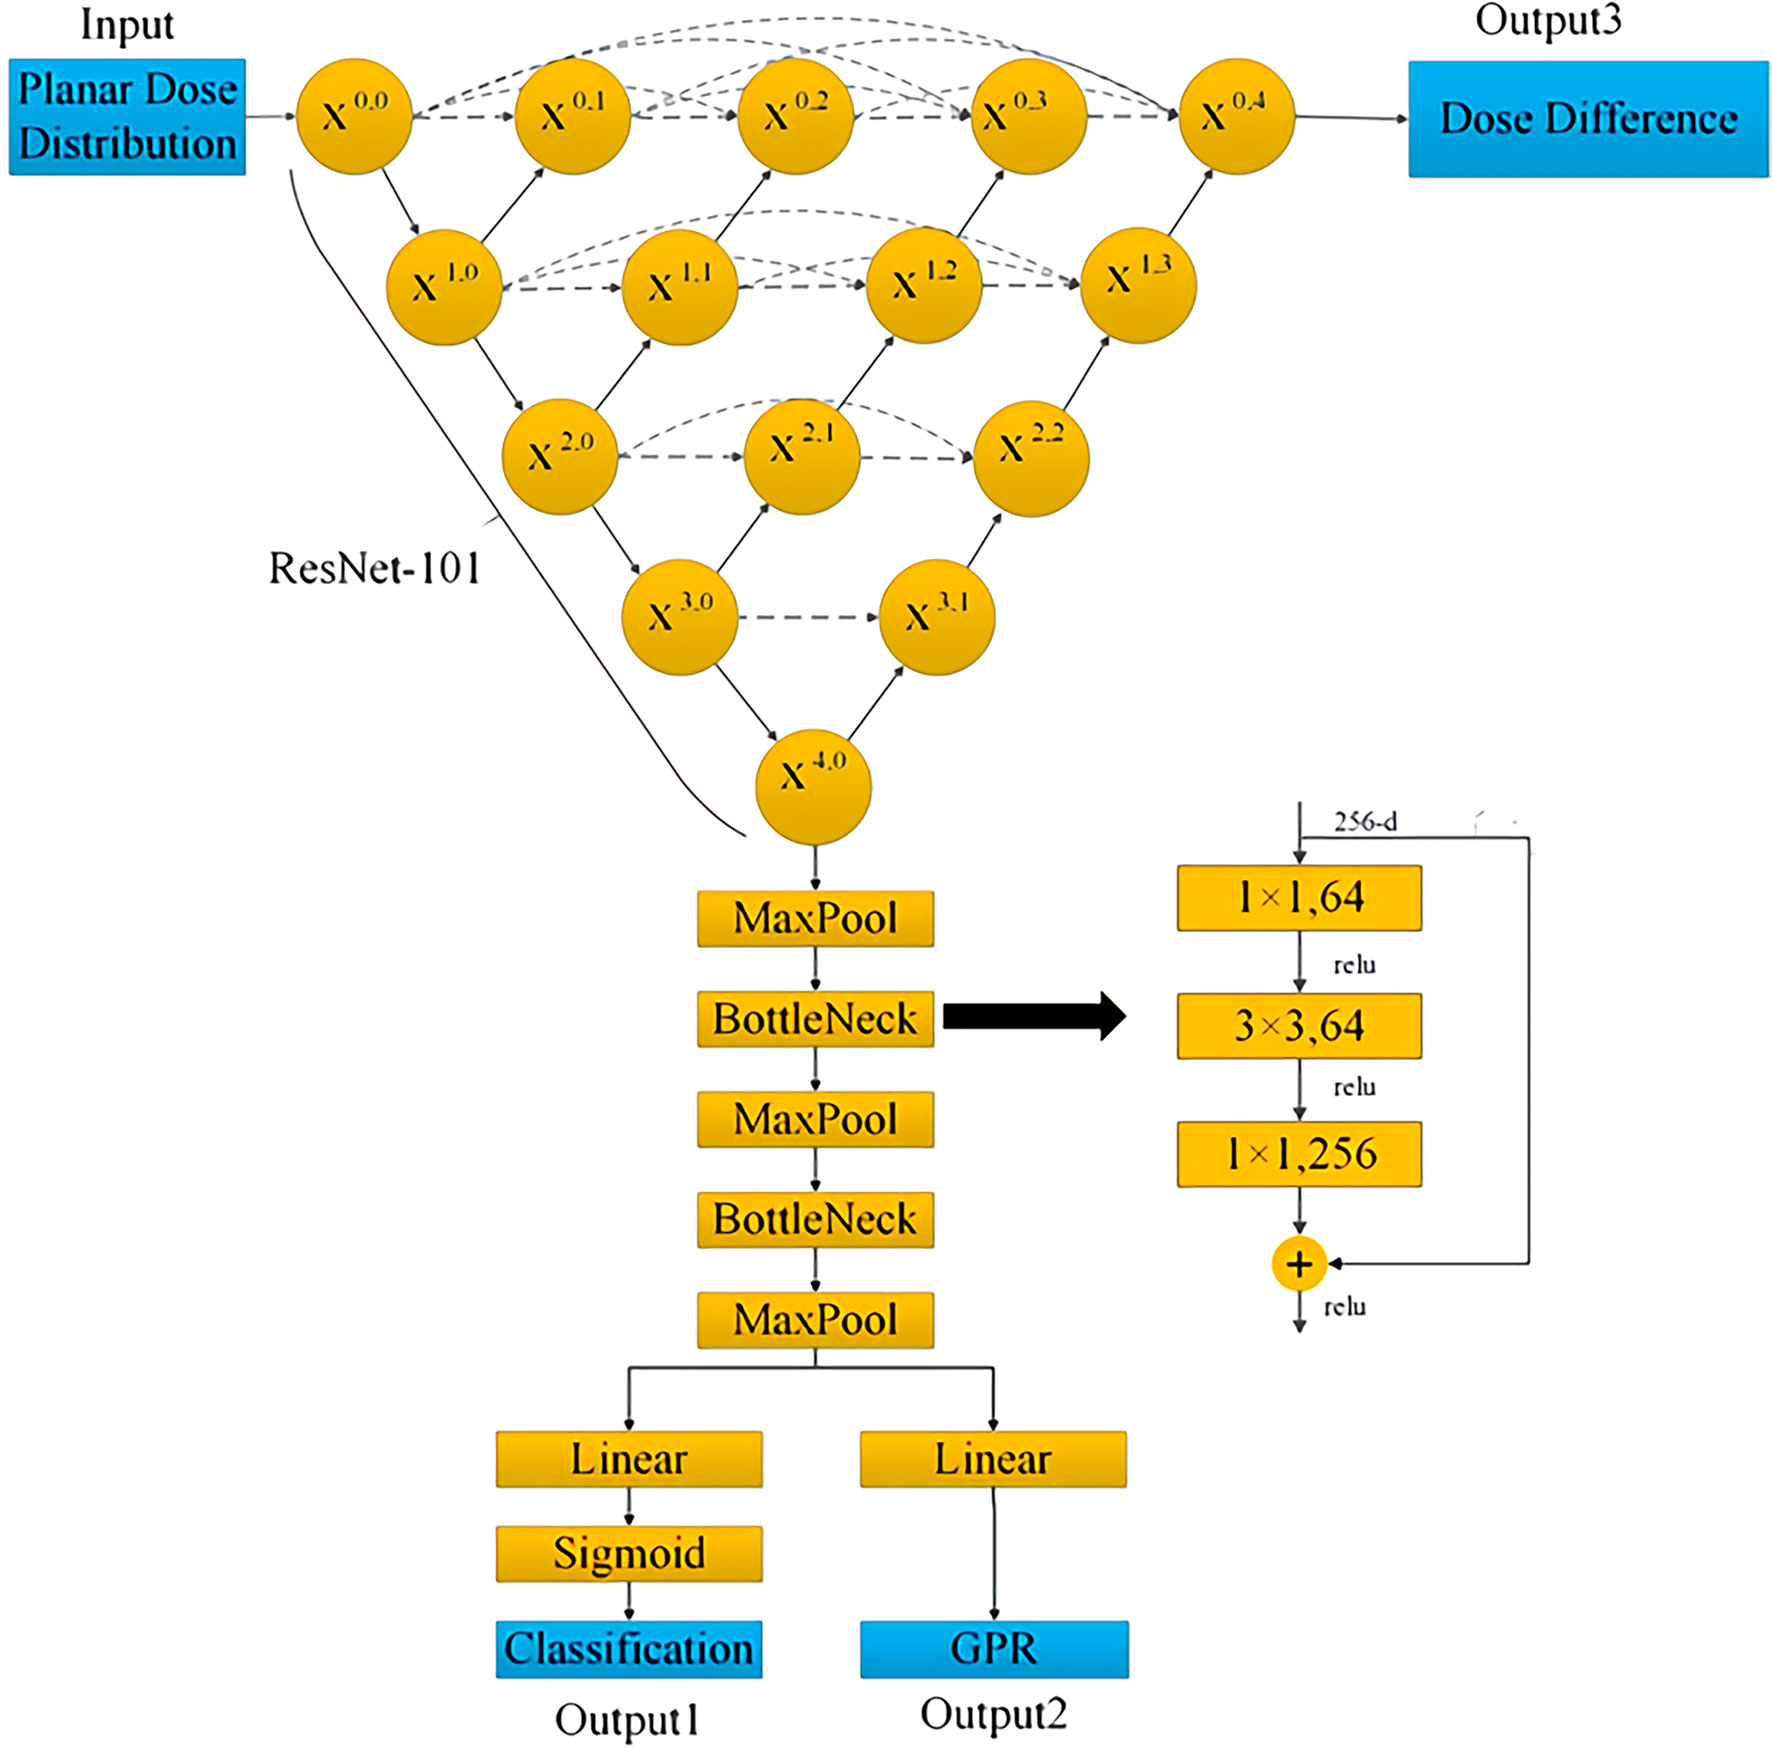

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.467143 Val loss 0.335083 Dice 0.893492 JaccardIndex 0.778265
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.320650 Val loss 0.312566 Dice 0.898884 JaccardIndex 0.790015
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.306954 Val loss 0.312297 Dice 0.899468 JaccardIndex 0.791258
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.297637 Val loss 0.303854 Dice 0.902123 JaccardIndex 0.795890
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.287654 Val loss 0.307625 Dice 0.901453 JaccardIndex 0.794356
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.276903 Val loss 0.314600 Dice 0.900356 JaccardIndex 0.792767
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.263440 Val loss 0.323225 Dice 0.899024 JaccardIndex 0.790265
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.248635 Val loss 0.331592 Dice 0.898356 JaccardIndex 0.788816
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.233837 Val loss 0.338008 Dice 0.897013 JaccardIndex 0.784381
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.219148 Val loss 0.344056 Dice 0.897395 JaccardIndex 0.787370
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.205892 Val loss 0.350824 Dice 0.897414 JaccardIndex 0.786726
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.195299 Val loss 0.354426 Dice 0.897189 JaccardIndex 0.786356
---


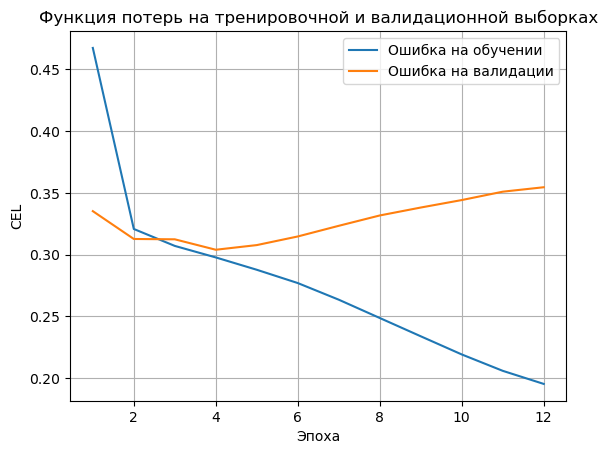

0it [00:00, ?it/s]

('model_unet_plus_plus_3',
 12,
 0.33822062238804806,
 tensor(0.8961),
 tensor(0.7869),
 10036.309300422668)

In [20]:
# Параметры 1
model = smp.UnetPlusPlus(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 12 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = optim.SGD(model.parameters(), lr=0.01, momentum=0.9) # оптимайзер
scheduler1 = torch.optim.lr_scheduler.ExponentialLR(optimizer, gamma=0.9) # первый шедулер
scheduler2 = torch.optim.lr_scheduler.MultiStepLR(optimizer, milestones=[30,80], gamma=0.1) # второй шедулер
scheduler = torch.optim.lr_scheduler.ChainedScheduler([scheduler1, scheduler2]) # объединенный шедулер

train_and_save_model(model, num_epochs, batch_size_train,
    batch_size_test,
    criterion,
    optimizer,
    scheduler, 'model_unet_plus_plus_1')

Видно, что модель переобучилась. Проведем процедуру улучшения модели: изменим оптимайзер и шедулер

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.466388 Val loss 0.330831 Dice 0.895373 JaccardIndex 0.782648
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.330993 Val loss 0.326670 Dice 0.894877 JaccardIndex 0.784063
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.315080 Val loss 0.306257 Dice 0.901279 JaccardIndex 0.795710
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.298347 Val loss 0.302325 Dice 0.901811 JaccardIndex 0.796333
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.288942 Val loss 0.298409 Dice 0.903489 JaccardIndex 0.799223
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.328050 Val loss 0.313135 Dice 0.898589 JaccardIndex 0.791092
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.315690 Val loss 0.315795 Dice 0.897444 JaccardIndex 0.786887
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.303533 Val loss 0.303685 Dice 0.902337 JaccardIndex 0.797818
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.298632 Val loss 0.304587 Dice 0.901118 JaccardIndex 0.796152
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.292588 Val loss 0.301853 Dice 0.902414 JaccardIndex 0.796428
---


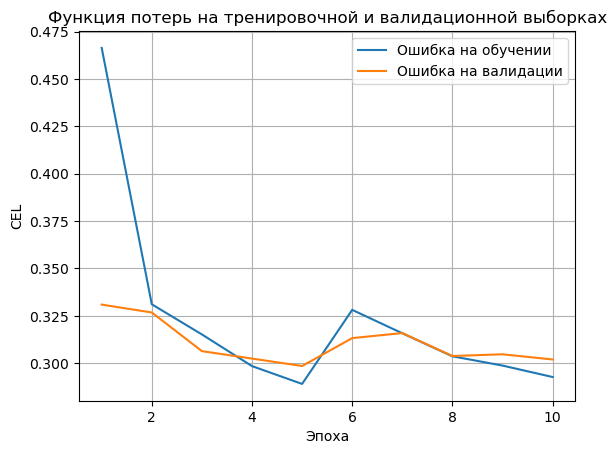

0it [00:00, ?it/s]

('model_unet_plus_plus_1',
 10,
 0.2956502288825997,
 tensor(0.9001),
 tensor(0.7904),
 9651.709692239761)

In [17]:
# Параметры 2
model = smp.UnetPlusPlus(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 10 # Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_unet_plus_plus_2')

Модель не переобучилась и ошибка снизилась в сравнении с первой. Попробуем добиться хороших показателей, увеличив число эпох до 50 и добавив регуляризацию.

In [ ]:
# Параметры 3
model = smp.UnetPlusPlus(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 50 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.01) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6)

train_and_save_model(model, num_epochs, batch_size_train,
    batch_size_test,
    criterion,
    optimizer,
    scheduler, 'model_test')

К сожалению, график здесь отсуствует, но он сохранен и будет выведен внизу. См. п.5

# 4.2 Модель DeepLabV3
Модель имеет следующую архитектуру:
* Извлечение признаков просиходит с помощью базовой сети (в нашем случае ResNet).
* Чтобы управлять размером карты объектов, в последних нескольких слоях базовой сети используется точечная свертка.
* Поверх извлеченных объектов из базовой сети добавляется сеть ASPP (Atrous Spatial Pyramid Pooling), проводящая пулинг  для классификации каждого пикселя в соответствии с контекстом.
ASPP предсталвяет собой несколько сверток с разными ядрами на разных уровнях пираммиды. То есть применяется четыре свертки с разным расстоянием между 9 пикселями (обозначен, как __rate__ на рисунке). Затем все признаки объединяются и идут на вход в полносвязные линейные слои. Достоинство данного метода заключается в том, что он получает контекстную информацию на разных уровнях детализации изображения.  Отличие от SPP заключается в том, что в SPP свертки идут последовательно, а в ASPP параллельно. Общий принцип работы ASPP хорошо представлен на рисунке
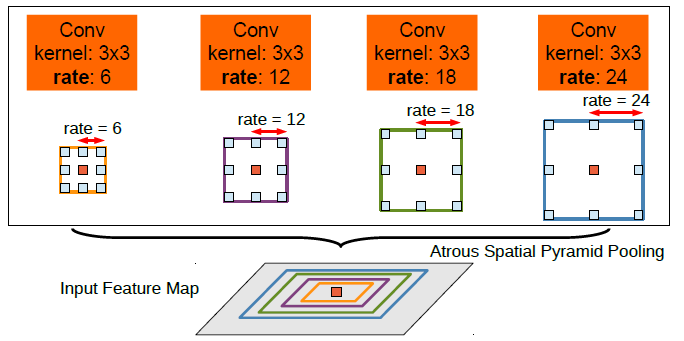

Выходом модели является тензор формой (1, C, H, W), где
* С- число классов
* H- высота картинки
* W- ширина картинки\
Архитектура DeepLabV3 видна на рисунке
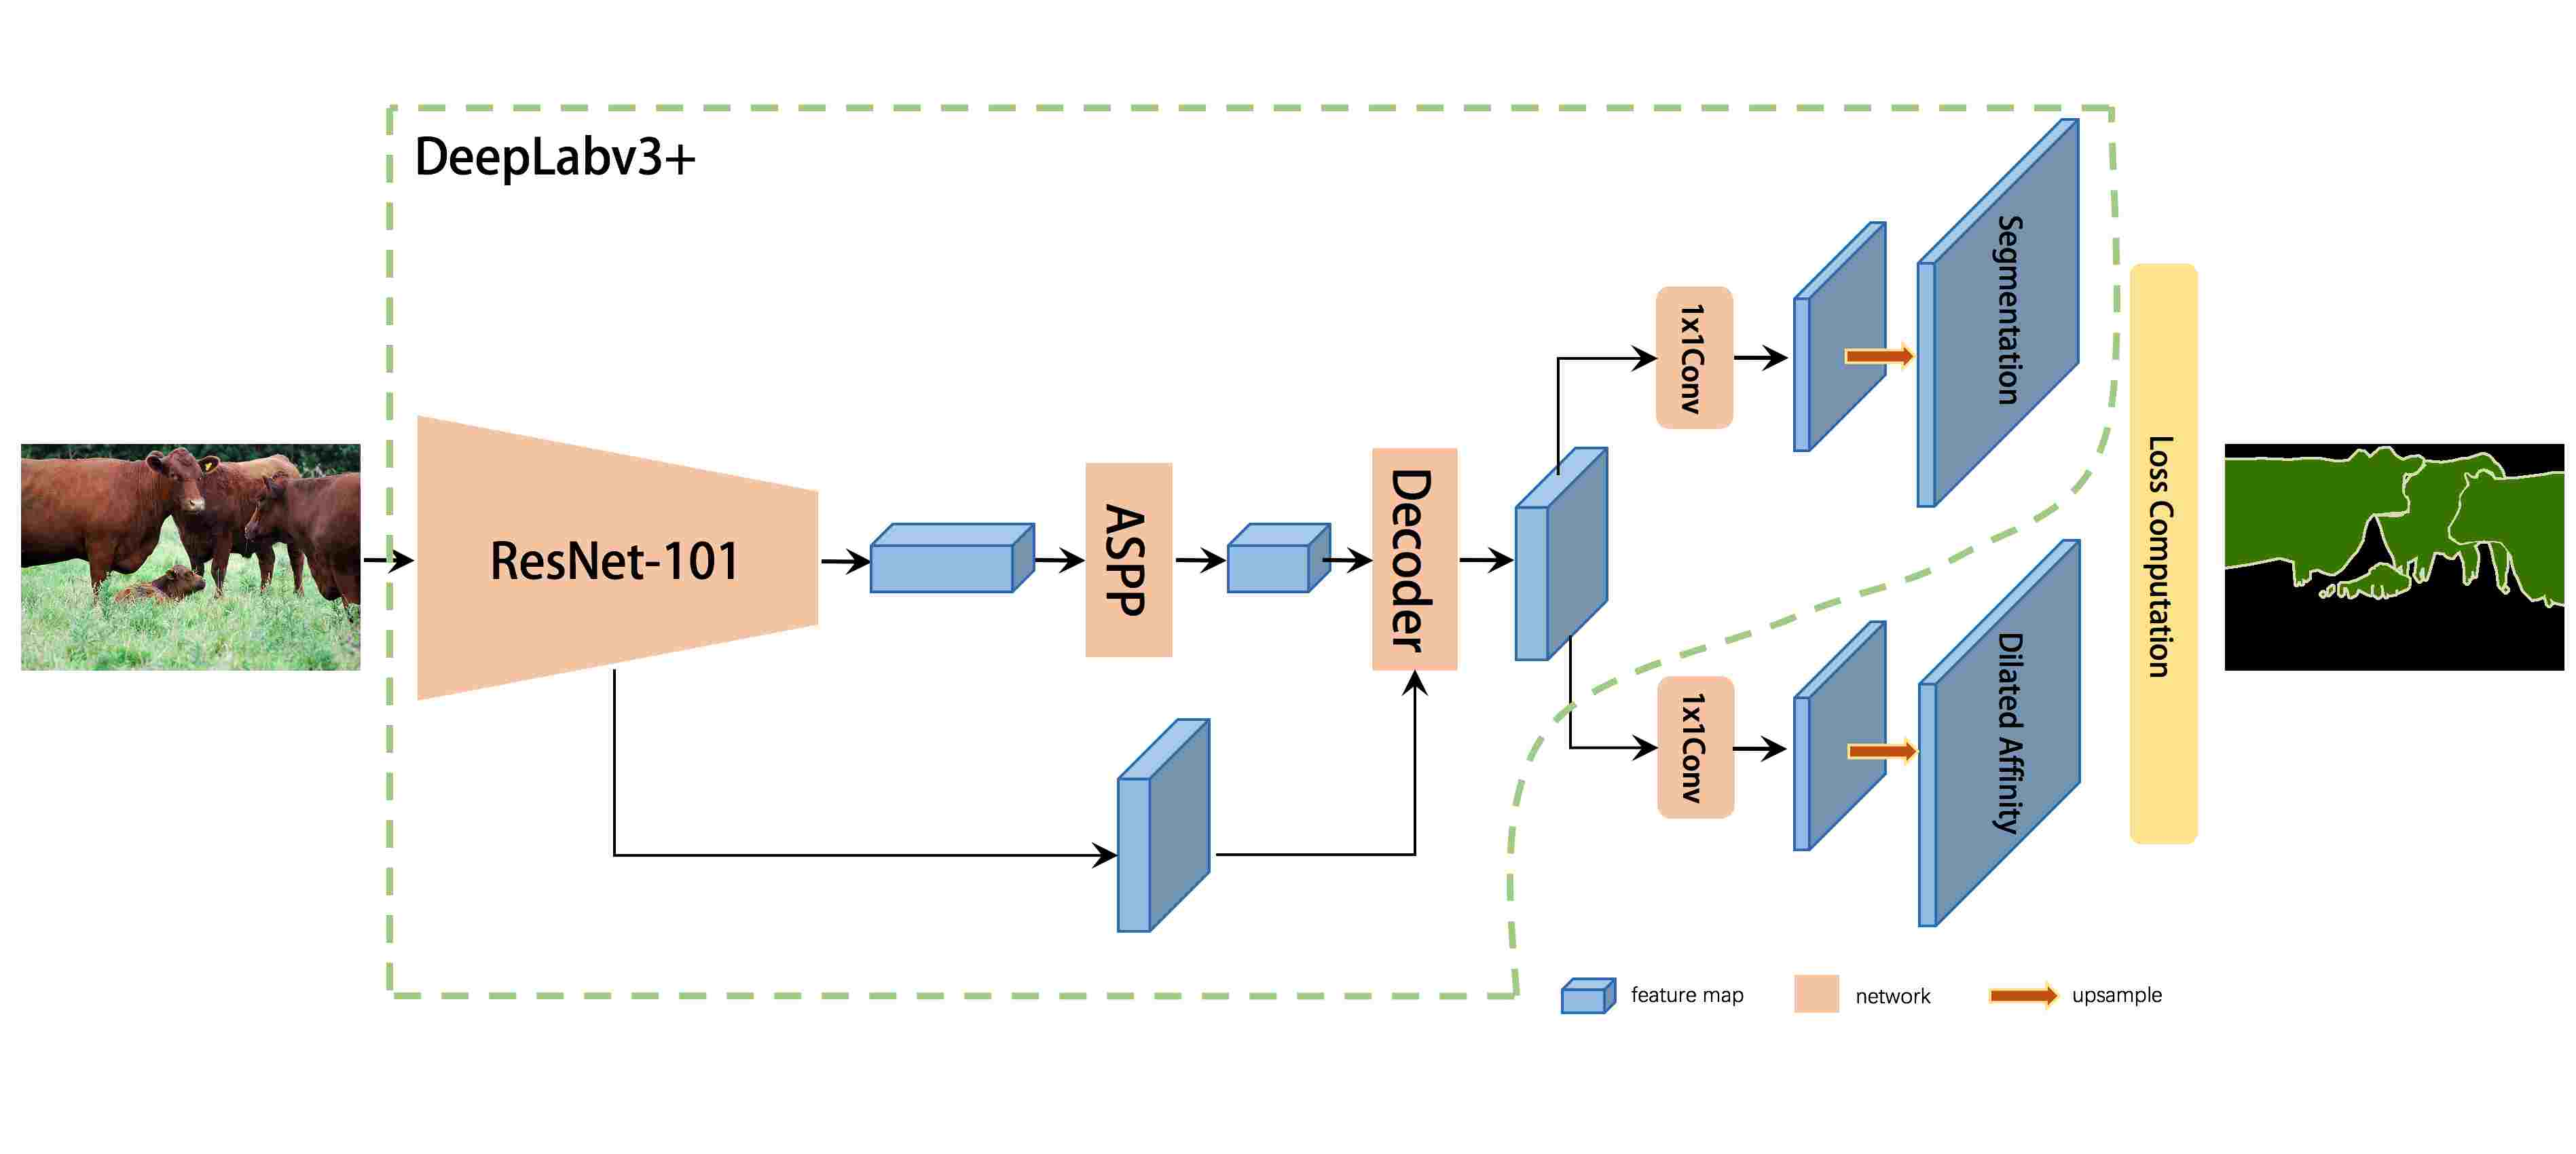

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 1.758081 Val loss 1.356880 Dice 0.631502 JaccardIndex 0.288313
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 1.180711 Val loss 1.008376 Dice 0.710939 JaccardIndex 0.372671
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.982030 Val loss 0.887485 Dice 0.735712 JaccardIndex 0.412706
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.899003 Val loss 0.842679 Dice 0.748954 JaccardIndex 0.437509
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.872265 Val loss 0.830239 Dice 0.753027 JaccardIndex 0.445812
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.815689 Val loss 0.729912 Dice 0.778988 JaccardIndex 0.493730
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.737086 Val loss 0.666134 Dice 0.794395 JaccardIndex 0.522299
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.684712 Val loss 0.618008 Dice 0.809778 JaccardIndex 0.557917
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.648856 Val loss 0.591027 Dice 0.820577 JaccardIndex 0.589371
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.617131 Val loss 0.562295 Dice 0.827603 JaccardIndex 0.610738
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.598577 Val loss 0.551703 Dice 0.832740 JaccardIndex 0.626138
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.587442 Val loss 0.543858 Dice 0.835664 JaccardIndex 0.637704
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.580678 Val loss 0.537653 Dice 0.835984 JaccardIndex 0.640009
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.576026 Val loss 0.534951 Dice 0.838472 JaccardIndex 0.645589
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.575156 Val loss 0.535174 Dice 0.839264 JaccardIndex 0.647910
---


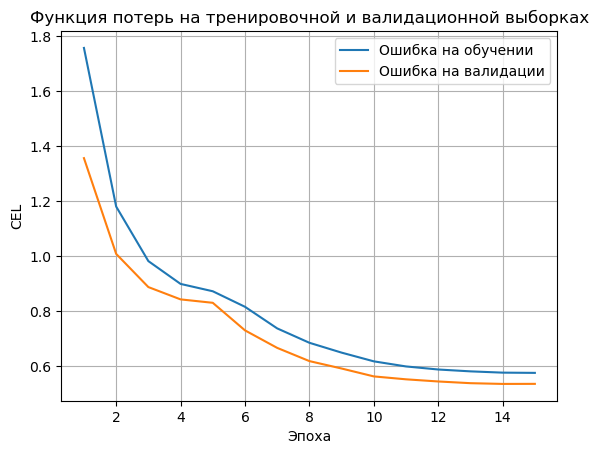

0it [00:00, ?it/s]

('vodel_deep_labv3_3',
 15,
 0.5394182885791541,
 tensor(0.8384),
 tensor(0.6446),
 12530.238382816315)

In [25]:
# Параметры 1
model = smp.DeepLabV3(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 15 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.SGD(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер

train_and_save_model(model, num_epochs, batch_size_train,
    batch_size_test,
    criterion,
    optimizer,
    scheduler, 'model_deep_labv3_1')

Благодаря регуляризации модель не переобучается, однако обучение идет сильно дольше, видимо из-за большого значения параметра `weight-decay` для данной модели и задачи. Возможно ошибка заключается в неверном выборе шедулера, попробуем изменить его.

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.505681 Val loss 0.351272 Dice 0.889203 JaccardIndex 0.767289
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.340563 Val loss 0.325117 Dice 0.897799 JaccardIndex 0.784159
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.327698 Val loss 0.321919 Dice 0.898684 JaccardIndex 0.786059
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.325696 Val loss 0.322652 Dice 0.898507 JaccardIndex 0.785678
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.325837 Val loss 0.321433 Dice 0.898607 JaccardIndex 0.785911
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.326148 Val loss 0.322033 Dice 0.898642 JaccardIndex 0.785918
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.324933 Val loss 0.322017 Dice 0.898494 JaccardIndex 0.785682
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.325263 Val loss 0.321821 Dice 0.898626 JaccardIndex 0.785861
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.325683 Val loss 0.321488 Dice 0.898482 JaccardIndex 0.785740
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.325658 Val loss 0.322181 Dice 0.898580 JaccardIndex 0.785935
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.325891 Val loss 0.321402 Dice 0.898659 JaccardIndex 0.786031
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.325492 Val loss 0.321777 Dice 0.898589 JaccardIndex 0.785832
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.325915 Val loss 0.322188 Dice 0.898474 JaccardIndex 0.785770
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.325163 Val loss 0.321719 Dice 0.898667 JaccardIndex 0.785993
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.325031 Val loss 0.321759 Dice 0.898543 JaccardIndex 0.785744
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 16
Train Loss 0.325595 Val loss 0.321887 Dice 0.898451 JaccardIndex 0.785696
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 17
Train Loss 0.325791 Val loss 0.322086 Dice 0.898430 JaccardIndex 0.785654
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 18
Train Loss 0.325096 Val loss 0.321535 Dice 0.898564 JaccardIndex 0.785767
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 19
Train Loss 0.325598 Val loss 0.322242 Dice 0.898466 JaccardIndex 0.785594
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 20
Train Loss 0.325475 Val loss 0.322350 Dice 0.898433 JaccardIndex 0.785628
---


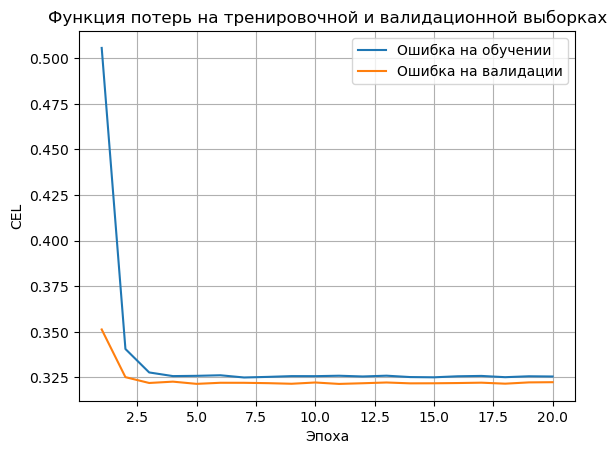

0it [00:00, ?it/s]

('model_deep_labv3_2',
 20,
 0.31991129593931067,
 tensor(0.8940),
 tensor(0.7770),
 15660.422923088074)

In [42]:
# Параметры 2
model = smp.DeepLabV3(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 20 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [i for i in range(num_epochs)]) # шедулер


train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_deep_labv3_2')

Благодаря регуляризации модель не переобучилась на 20 эпохах. Так же с новым шедулером обучение пошло быстрее. Можно сказать, что получена хорошая модель. Однако обучение шло дольше, чем для модели `Unet++`

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.594722 Val loss 1.296462 Dice 0.554581 JaccardIndex 0.348926
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.525234 Val loss 0.524739 Dice 0.864248 JaccardIndex 0.722112
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.532773 Val loss 0.559912 Dice 0.860197 JaccardIndex 0.711349
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.571725 Val loss 0.599278 Dice 0.857120 JaccardIndex 0.710043
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.579237 Val loss 0.549658 Dice 0.871086 JaccardIndex 0.731776
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.573736 Val loss 0.562759 Dice 0.865632 JaccardIndex 0.723329
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.571306 Val loss 0.506285 Dice 0.875467 JaccardIndex 0.738865
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.570088 Val loss 0.645263 Dice 0.835504 JaccardIndex 0.676349
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.566807 Val loss 0.519655 Dice 0.877888 JaccardIndex 0.742807
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.571232 Val loss 0.933758 Dice 0.733602 JaccardIndex 0.508197
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.568721 Val loss 0.554706 Dice 0.862158 JaccardIndex 0.715921
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.564266 Val loss 0.716985 Dice 0.810567 JaccardIndex 0.648030
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.568772 Val loss 0.593933 Dice 0.853849 JaccardIndex 0.696308
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.568227 Val loss 0.536282 Dice 0.874114 JaccardIndex 0.735388
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.566662 Val loss 0.533799 Dice 0.874982 JaccardIndex 0.738011
---


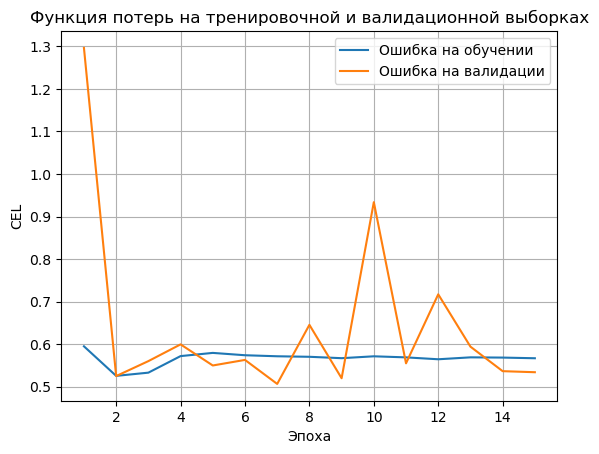

0it [00:00, ?it/s]

('model_deep_labv3_3',
 15,
 0.5437424040769806,
 tensor(0.8687),
 tensor(0.7341),
 13844.597742080688)

In [45]:
# Параметры 3
model = smp.DeepLabV3(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 15 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.05) # оптимайзер
scheduler = None # шедулер


train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_deep_labv3_3')

Значение функции потерь большое. Модель скорее всего недообучилась.

# 4.3 Модель PAN
Данная модель служит для использования глобальной контекстной информации для семантической сегментации. Модель совмещает достоинства механизма внимания и пространственной пираммиды. Опишем данные механизмы:
* __Global Context Attention__: Данный механизм позволяет установить контекст участков изображения, что приводит к более качественной классификации пикселей. Авторы PAN используют глобальный оператор пула, добавляемый к ветвям декодера, чтобы выбирать дискриминирующие многоразрешающие признаковые представления.
* __Spatial Pyramid__: Этот механизм использует параллельное объединение, описанное в пункте про ASPP для выделения многомасштбаной контекстной информации. При классификации пикселя используется информация о его окуржении (контексте), причем в разных масштбах, что так же повышает качество алгоритма.

__Feature Pyramid Attention__: Чтобы лучше извлекать контекст из различных масштабов пирамиды, авторы предлагают использование 3×3, 5×5, 7×7 ядер для свертки в пирамидальной структуре. Благодаря последней происходит последовательная интеграция информации о различных масштабах. После этого полученные объекты попиксельно умножаются на объекты внимания. Авторы статьи отмечают, что предлагаемый механизм позволяет объединять информацию разного масштаба и обеспечивает лучшее внимание к каждому пикселю. Вдобавок, в отличие от PSPNet и ASPP объединение различных карт признаков перед слоем свертки с уменьшением канала контекстная информация умножается на исходную карту признаков, полученную базовым слоем ResNet.

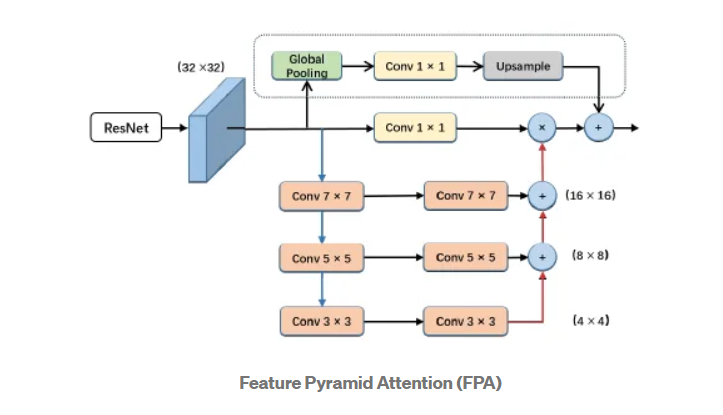

__Global Attention Upsample__: Выступает в роли декодера. Выполняет объединение средних для представления глобального контекста низкоуровневых признаков через свертку с ядром размера (3,3). Глобальный констекст для высокоуровневых признаков создается путем свертки с ядром (1,1) с нормализацией батча и функцией активации ReLU. Затем они умножаются на результат свертки низкоуровневых признаков. Далее результат проходит через объект внимания. Этот модуль более эффективно развертывает карты признаков различного масштаба и использует высокоуровневые функции, предоставляя руководящую информацию для низкоуровневых карт признаков простым способом.

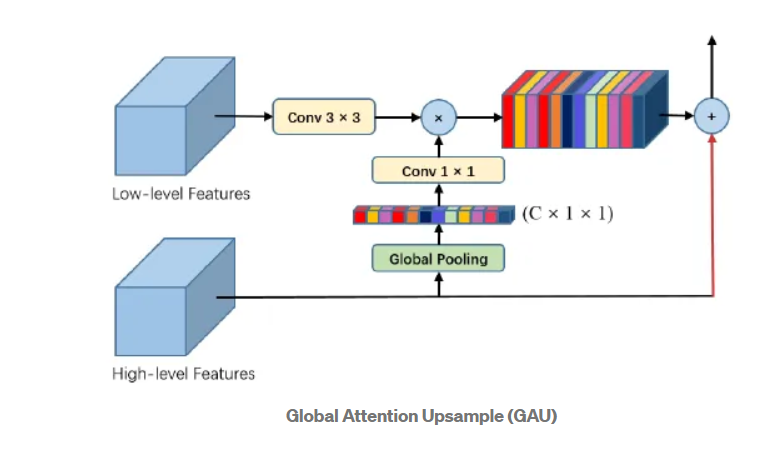

Нейронная сеть выглядит следующим образом: 
1. Сверточная нейронная сеть (ResNet) для извлечения карты признаков.
2. Применяем свертку с `rate` = 2.
3. Получаем карты признаков и обрабатываем их через GAU и FPA.
4. Проводим апсэмплинг, чтобы получить размер исходного изображения.

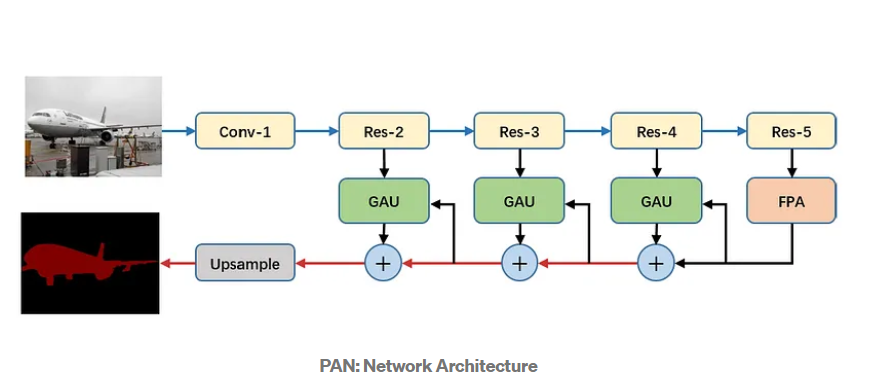

  0%|          | 0/40 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.519679 Val loss 0.639562 Dice 0.795355 JaccardIndex 0.605417
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.453401 Val loss 0.465909 Dice 0.852480 JaccardIndex 0.700324
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.403544 Val loss 0.396242 Dice 0.876694 JaccardIndex 0.748434
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.374933 Val loss 0.362327 Dice 0.883921 JaccardIndex 0.759879
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.350285 Val loss 0.340863 Dice 0.891582 JaccardIndex 0.773548
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.417240 Val loss 0.380108 Dice 0.878081 JaccardIndex 0.748079
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.398295 Val loss 0.405427 Dice 0.871114 JaccardIndex 0.736287
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.394124 Val loss 0.377322 Dice 0.877526 JaccardIndex 0.748112
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.381277 Val loss 0.377598 Dice 0.877571 JaccardIndex 0.748233
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.377974 Val loss 0.366436 Dice 0.881376 JaccardIndex 0.755259
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.362662 Val loss 0.356462 Dice 0.885079 JaccardIndex 0.760515
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.352031 Val loss 0.345270 Dice 0.887557 JaccardIndex 0.765578
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.344963 Val loss 0.340403 Dice 0.889358 JaccardIndex 0.769508
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.337050 Val loss 0.332067 Dice 0.892188 JaccardIndex 0.774300
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.331828 Val loss 0.329612 Dice 0.892995 JaccardIndex 0.775290
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 16
Train Loss 0.399640 Val loss 0.367339 Dice 0.880963 JaccardIndex 0.752357
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 17
Train Loss 0.388969 Val loss 0.371737 Dice 0.879031 JaccardIndex 0.750732
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 18
Train Loss 0.383745 Val loss 0.377560 Dice 0.877366 JaccardIndex 0.747436
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 19
Train Loss 0.375433 Val loss 0.478596 Dice 0.847610 JaccardIndex 0.689316
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 20
Train Loss 0.379684 Val loss 0.361955 Dice 0.882658 JaccardIndex 0.758311
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 21
Train Loss 0.377834 Val loss 0.368937 Dice 0.881011 JaccardIndex 0.754109
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 22
Train Loss 0.370593 Val loss 0.363474 Dice 0.880898 JaccardIndex 0.754717
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 23
Train Loss 0.370231 Val loss 0.482463 Dice 0.842889 JaccardIndex 0.684351
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 24
Train Loss 0.364977 Val loss 0.355533 Dice 0.884604 JaccardIndex 0.758576
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 25
Train Loss 0.360899 Val loss 0.345592 Dice 0.887390 JaccardIndex 0.766218
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 26
Train Loss 0.359830 Val loss 0.349145 Dice 0.885583 JaccardIndex 0.762389
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 27
Train Loss 0.351991 Val loss 0.356959 Dice 0.883065 JaccardIndex 0.757733
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 28
Train Loss 0.348048 Val loss 0.353930 Dice 0.885145 JaccardIndex 0.761025
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 29
Train Loss 0.345136 Val loss 0.340700 Dice 0.888848 JaccardIndex 0.767913
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 30
Train Loss 0.338503 Val loss 0.337090 Dice 0.889871 JaccardIndex 0.769940
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 31
Train Loss 0.334942 Val loss 0.333025 Dice 0.891419 JaccardIndex 0.773272
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 32
Train Loss 0.331853 Val loss 0.329167 Dice 0.892565 JaccardIndex 0.775229
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 33
Train Loss 0.328543 Val loss 0.328227 Dice 0.892869 JaccardIndex 0.775699
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 34
Train Loss 0.326409 Val loss 0.326951 Dice 0.893395 JaccardIndex 0.776529
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 35
Train Loss 0.324252 Val loss 0.326516 Dice 0.893593 JaccardIndex 0.777019
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 36
Train Loss 0.407607 Val loss 0.504401 Dice 0.834236 JaccardIndex 0.684120
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 37
Train Loss 0.383889 Val loss 0.382308 Dice 0.875617 JaccardIndex 0.745561
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 38
Train Loss 0.377268 Val loss 0.375553 Dice 0.878332 JaccardIndex 0.748660
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 39
Train Loss 0.376603 Val loss 0.384376 Dice 0.873828 JaccardIndex 0.740841
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 40
Train Loss 0.380145 Val loss 0.387796 Dice 0.875281 JaccardIndex 0.742797
---


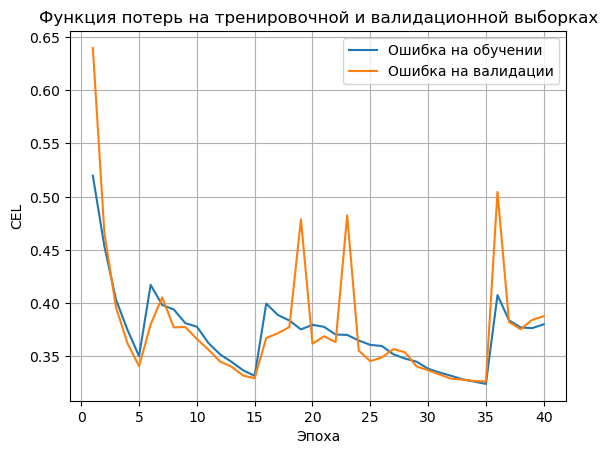

0it [00:00, ?it/s]

('model_PAN_1',
 40,
 0.3918769373367768,
 tensor(0.8691),
 tensor(0.7334),
 22267.954711437225)

In [47]:
# Параметры 1
model = smp.PAN(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 40 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.025) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_PAN_1')

Модель обучается скачками, иногда рост ошибки на валидации большой, но на 40 эпохе в целом переобучения не наблюдается. Однако для 40 эпох значение функции ошибки остается большим в сравнении с предудущими моделями.

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.644443 Val loss 0.370123 Dice 0.884886 JaccardIndex 0.759700
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.356707 Val loss 0.347686 Dice 0.890072 JaccardIndex 0.769975
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.342915 Val loss 0.345640 Dice 0.890593 JaccardIndex 0.770534
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.339848 Val loss 0.345001 Dice 0.890794 JaccardIndex 0.770910
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.339428 Val loss 0.345747 Dice 0.890707 JaccardIndex 0.770753
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.339425 Val loss 0.345218 Dice 0.890667 JaccardIndex 0.770714
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.340176 Val loss 0.344667 Dice 0.890670 JaccardIndex 0.770506
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.340726 Val loss 0.345078 Dice 0.890663 JaccardIndex 0.770562
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.339288 Val loss 0.344427 Dice 0.890962 JaccardIndex 0.770968
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.339708 Val loss 0.345660 Dice 0.890810 JaccardIndex 0.770960
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.339782 Val loss 0.345234 Dice 0.890770 JaccardIndex 0.770945
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.339310 Val loss 0.344378 Dice 0.890913 JaccardIndex 0.771042
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.339404 Val loss 0.344934 Dice 0.890928 JaccardIndex 0.771220
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.339753 Val loss 0.345055 Dice 0.890852 JaccardIndex 0.771076
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.340927 Val loss 0.345075 Dice 0.890817 JaccardIndex 0.770513
---


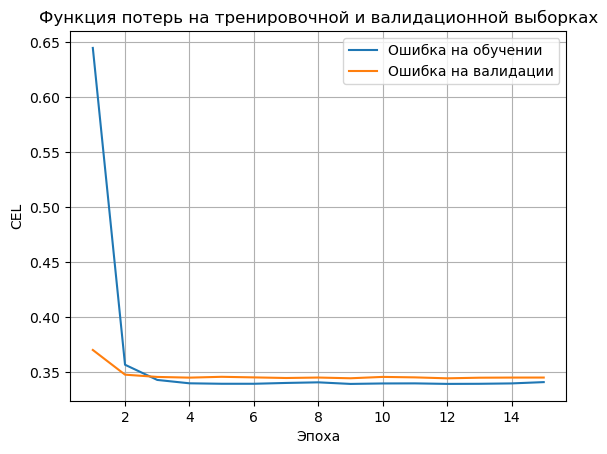

0it [00:00, ?it/s]

('model_PAN_2',
 15,
 0.33528586000676514,
 tensor(0.8878),
 tensor(0.7643),
 8624.808004379272)

In [46]:
# Параметры 2
model = smp.PAN(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 15 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler  = torch.optim.lr_scheduler.MultiStepLR(optimizer, [i for i in range(num_epochs)]) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_PAN_2')

После замены шедулера, обучение пошло быстрее и без скачков, что объясняется свойствами функции `cos`($\cdot$). Ошибка на валидации больше, чем на тренирочной выборке, но большого разрыва не наблюдаем. Модель еще не переобучилась.

Попробуем обучать без регулризации.

  0%|          | 0/13 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.396268 Val loss 0.324278 Dice 0.894584 JaccardIndex 0.782980
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.322829 Val loss 0.319691 Dice 0.896266 JaccardIndex 0.782518
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.308293 Val loss 0.309575 Dice 0.900306 JaccardIndex 0.792331
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.289337 Val loss 0.305034 Dice 0.901658 JaccardIndex 0.794278
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.259179 Val loss 0.307080 Dice 0.900798 JaccardIndex 0.792903
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.316118 Val loss 0.307292 Dice 0.901392 JaccardIndex 0.793686
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.296869 Val loss 0.311510 Dice 0.899471 JaccardIndex 0.789883
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.288539 Val loss 0.309249 Dice 0.900107 JaccardIndex 0.792038
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.266129 Val loss 0.315499 Dice 0.898427 JaccardIndex 0.788107
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.238730 Val loss 0.328066 Dice 0.894757 JaccardIndex 0.780727
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.209772 Val loss 0.335339 Dice 0.898883 JaccardIndex 0.788970
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.181172 Val loss 0.355543 Dice 0.897504 JaccardIndex 0.786384
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.158369 Val loss 0.369709 Dice 0.897188 JaccardIndex 0.785719
---


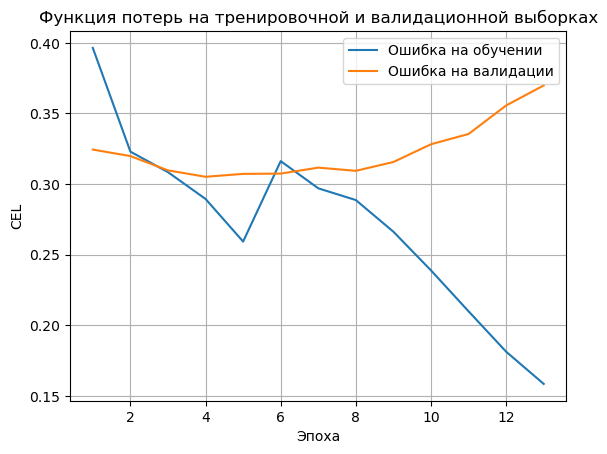

0it [00:00, ?it/s]

('model_PAN_3',
 13,
 0.3563513007467733,
 tensor(0.8950),
 tensor(0.7807),
 7243.869646310806)

In [48]:
# Параметры 3
model = smp.PAN(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 13 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_PAN_3')

Видно, что без регуляризации модель переобучилась, так как ошибка на валидации сильно больше ошибка на обучающй выборке.

# 4.4 Модель PSPNet

Данная модель, по словам авторов, направлена на исправление основных ошибок полносвязных глубоких сверточных сетей. В статье, посвященной PSPNet отмечается, что FCN не хватает глобальной инофрмации о контексте. Выше было отмечено, что проблема данного рода решается различными способами. Авторы PSPNet предлагают следующее решение: __Pyramid Pooling Module__.

Для получения карты признаков по-прежнему используется модель ResNet. Затем карта признаков проходит через глобальный усреднительный (авт.) пулинг. Данный метод позволяет получить глобальную контекстную информацию. На рисунке представлен данный модуль.
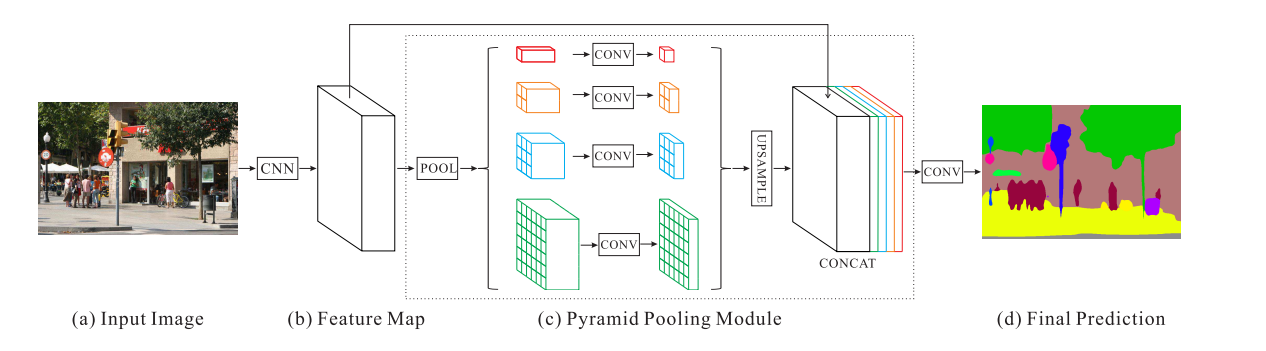
Согласно источнику,  __Pyramid Pooling Module__ объединяет функции в четырех
различных пирамидальных масштабах. Самый грубый уровень, выделенный
красным, - это глобальное объединение для генерации выходных данных из одной ячейки.
Следующий уровень пирамиды разделяет карту объектов на различные подобласти и формирует объединенное представление для разных местоположений. Выходные данные различных уровней в модуле объединения пирамид содержат карту объектов различных
размеров. Затем обработанные карты признаков разного размера приводятся к изначальными и конкатенируются с картой признаков после CNN и между собой, как финальный результат.

  0%|          | 0/25 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.466272 Val loss 0.362856 Dice 0.885675 JaccardIndex 0.764675
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.354927 Val loss 0.357076 Dice 0.887896 JaccardIndex 0.772716
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.331418 Val loss 0.340599 Dice 0.892077 JaccardIndex 0.779483
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.314132 Val loss 0.331987 Dice 0.896324 JaccardIndex 0.786262
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.295144 Val loss 0.327725 Dice 0.898196 JaccardIndex 0.788719
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.283533 Val loss 0.327918 Dice 0.898314 JaccardIndex 0.789259
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.283895 Val loss 0.327244 Dice 0.898223 JaccardIndex 0.788889
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.284348 Val loss 0.328059 Dice 0.898231 JaccardIndex 0.788939
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.284643 Val loss 0.328642 Dice 0.898123 JaccardIndex 0.788608
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.284643 Val loss 0.328374 Dice 0.898134 JaccardIndex 0.788879
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.283682 Val loss 0.327745 Dice 0.898196 JaccardIndex 0.788930
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.284331 Val loss 0.327740 Dice 0.898181 JaccardIndex 0.788802
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.284039 Val loss 0.328276 Dice 0.898253 JaccardIndex 0.788928
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.284298 Val loss 0.327970 Dice 0.898211 JaccardIndex 0.788927
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.284199 Val loss 0.328100 Dice 0.898168 JaccardIndex 0.788937
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 16
Train Loss 0.283767 Val loss 0.328417 Dice 0.898121 JaccardIndex 0.788848
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 17
Train Loss 0.283763 Val loss 0.327807 Dice 0.898259 JaccardIndex 0.789001
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 18
Train Loss 0.284422 Val loss 0.327821 Dice 0.898217 JaccardIndex 0.788738
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 19
Train Loss 0.284119 Val loss 0.329721 Dice 0.898079 JaccardIndex 0.788973
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 20
Train Loss 0.283847 Val loss 0.328254 Dice 0.898186 JaccardIndex 0.788963
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 21
Train Loss 0.283638 Val loss 0.328776 Dice 0.898064 JaccardIndex 0.788697
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 22
Train Loss 0.284185 Val loss 0.327793 Dice 0.898223 JaccardIndex 0.788938
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 23
Train Loss 0.284231 Val loss 0.328555 Dice 0.898041 JaccardIndex 0.788915
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 24
Train Loss 0.283703 Val loss 0.327356 Dice 0.898274 JaccardIndex 0.789119
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 25
Train Loss 0.283878 Val loss 0.327779 Dice 0.898305 JaccardIndex 0.789178
---


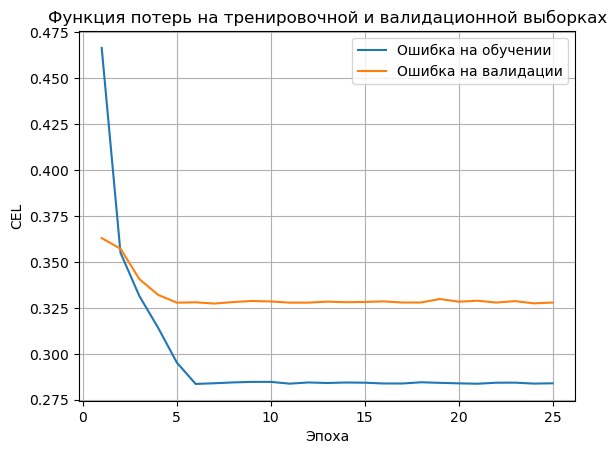

0it [00:00, ?it/s]

('model_PSPNet_1',
 25,
 0.2984584155966143,
 tensor(0.8992),
 tensor(0.7867),
 11080.699865818024)

In [14]:
# Параметры 1
model = smp.PSPNet(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 25 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_PSPNet_1')

Очень низкая в сравнении с валидацией ошибка может свидетельствовать о переобучении, вдобавок кривые обучения вышли на плато. Однако считаю целесообразным попробовать дообучить данную модель ввиду самой низкой ошибке на обучении.

  0%|          | 0/15 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 0.457458 Val loss 0.360477 Dice 0.886716 JaccardIndex 0.767373
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 0.359276 Val loss 0.344325 Dice 0.892395 JaccardIndex 0.775439
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 0.331815 Val loss 0.332403 Dice 0.894588 JaccardIndex 0.782595
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 0.309067 Val loss 0.326784 Dice 0.897253 JaccardIndex 0.786696
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 0.291751 Val loss 0.326335 Dice 0.898509 JaccardIndex 0.789759
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 0.331659 Val loss 0.334957 Dice 0.895700 JaccardIndex 0.784156
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 0.315457 Val loss 0.340961 Dice 0.894649 JaccardIndex 0.783932
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 0.304081 Val loss 0.342972 Dice 0.893629 JaccardIndex 0.782446
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 0.288035 Val loss 0.348369 Dice 0.896104 JaccardIndex 0.785635
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 0.270361 Val loss 0.347315 Dice 0.897780 JaccardIndex 0.787784
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.250945 Val loss 0.359983 Dice 0.897023 JaccardIndex 0.786195
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.233561 Val loss 0.369424 Dice 0.896606 JaccardIndex 0.786770
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.218836 Val loss 0.385277 Dice 0.896757 JaccardIndex 0.786537
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.207515 Val loss 0.392880 Dice 0.896178 JaccardIndex 0.785678
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.200605 Val loss 0.394008 Dice 0.896178 JaccardIndex 0.785582
---


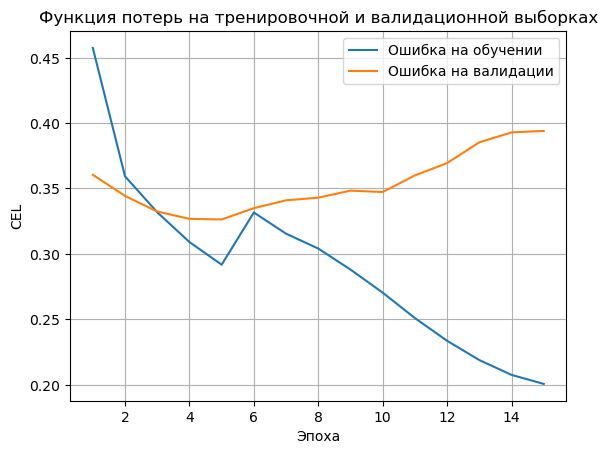

0it [00:00, ?it/s]

('model_PSPNet_2',
 15,
 0.3498694043547466,
 tensor(0.8951),
 tensor(0.7821),
 6723.620865106583)

In [15]:
# Параметры 2
model = smp.PSPNet(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 15 # число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_PSPNet_2')

Очевидно, что модель переобучилась.

  0%|          | 0/12 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 1
Train Loss 2.995569 Val loss 59.591585 Dice 0.209292 JaccardIndex 0.020929
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 2
Train Loss 3.353549 Val loss 3.527551 Dice 0.209292 JaccardIndex 0.020929
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 3
Train Loss 2.640280 Val loss 132.615756 Dice 0.208159 JaccardIndex 0.021900
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 4
Train Loss 3.569281 Val loss 15.055420 Dice 0.209292 JaccardIndex 0.020929
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 5
Train Loss 2.572147 Val loss 101.098334 Dice 0.209269 JaccardIndex 0.020951
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 6
Train Loss 3.511673 Val loss 739.574559 Dice 0.205323 JaccardIndex 0.022304
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 7
Train Loss 2.510878 Val loss 49.227327 Dice 0.103763 JaccardIndex 0.010380
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 8
Train Loss 3.202623 Val loss 567.159705 Dice 0.209292 JaccardIndex 0.020929
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 9
Train Loss 2.741983 Val loss 22.359822 Dice 0.103774 JaccardIndex 0.010377
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 10
Train Loss 3.302252 Val loss 10.948306 Dice 0.244236 JaccardIndex 0.037975
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 2.717917 Val loss 61.037183 Dice 0.093946 JaccardIndex 0.009395
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 3.215373 Val loss 410.494909 Dice 0.206538 JaccardIndex 0.021332
---


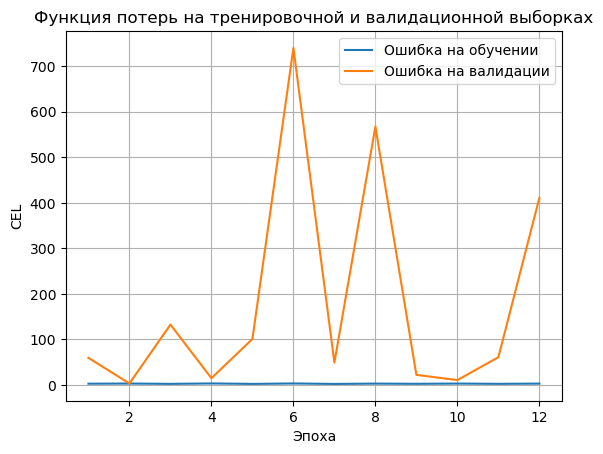

0it [00:00, ?it/s]

('model_PSPNet_3',
 12,
 402.78108628296945,
 tensor(0.2258),
 tensor(0.0231),
 5324.675271034241)

In [16]:
# Параметры 3
model = smp.PSPNet(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 12 # число эпох
learning_rate = 3 * 10**(-1) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.025) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер

train_and_save_model(model, num_epochs, 
    criterion,
    optimizer,
    scheduler, 'model_PSPNet_3')

Слишком большое значение ошибки на валидации. Модель получилась недообученной.

# 5 Тестирование моделей
Показателями качества в задачах сегментации из всего многообразия выделим следующие две:
#### 1. Индекс Жаккарда

Формульно можно выразить в следующем виде: $Jaccard = \frac{|A\cap B|}{|A \cup B|}$, где $A$- выход модели ( каждому пикселю присвоен класс детали), $B$- размеченный ответ. Данную метрику можно проинтерпретировать, как отношение перекрытия одного изображения другим к объединению. Через |$\cdot$| обозначены мощности множеств. Очевидно, что лучшая оценка: 1 (полное перекрытие), худшая- 0 (ни один пиксель не совпал). Метрика удобна тем, что учитываются так называемые ошибки первого и второго рода.
#### 2. Метрика Dice

Известна следующая формула: $Dice = \frac{2 \cdot |A\cap B|}{|A| + |B|}$, где обозначения аналогичны. Пересечение множеств- правильно предсказанные классы $TP_{i}, i = \overline{1, n}$, числитель представляет собой суммы мощностей выхода модели и размеченной фотографии, следовательно, туда входят, как правильно угаданные пиксели, так и неправильно. В литературе и статьях данный показатель называют f1-score для сегментации. 

Таким образом, были выбраны метрики, которые покажут реальное качество модели, то есть учтут возможный дизбаланс классов на фотографии. Это их отличает от простейшей метрики Accuracy, которая не показала бы нам настоящие результаты.

# 5.1 Модель Unet++

In [130]:
# Модель 1
model = smp.UnetPlusPlus(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
# Загружаем веса
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_unet_plus_plus_1.pth", map_location=torch.device("cuda:0")))
# Переводим модель в режим работы
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.338221, DICE = 0.896091, Jaccard_Index = 0.786885


__Замечание__: Остальные ячейки в этом пункте имеют аналогичные комментарии.

<h1><center>Модель Unet++ 1</center></h1>

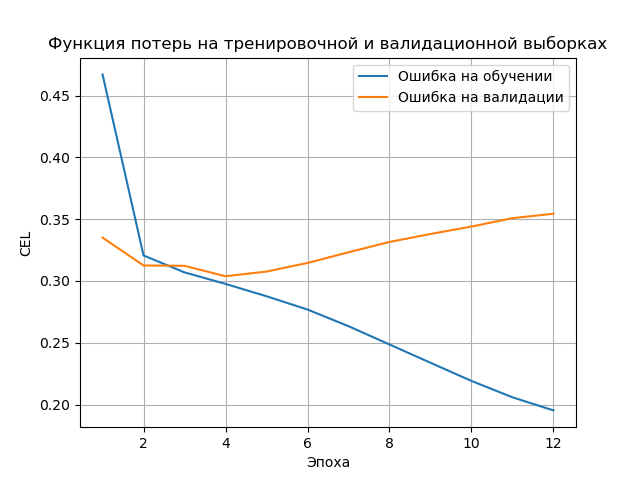

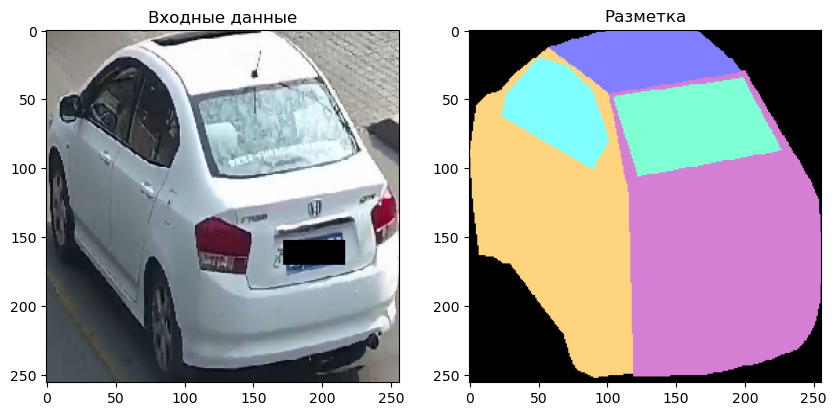

In [131]:
idx = 877
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

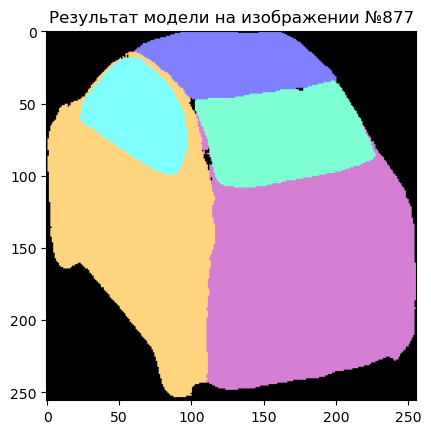

In [132]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: модель хоть и переобучилась, но имеет сравнительно неплохие метрики качества. Однако самое важное: умение модели сегментировать изображения. Сравнивая рисунок и разметку можно заметить, что модель правильно сглаживает углы для окон, однако неправильно определила фон.

In [124]:
# Модель 2
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model = smp.UnetPlusPlus(classes=10)
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_unet_plus_plus_2.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.29565, DICE = 0.900077, Jaccard_Index = 0.790379


<h1><center>Модель Unet++ 2</center></h1>

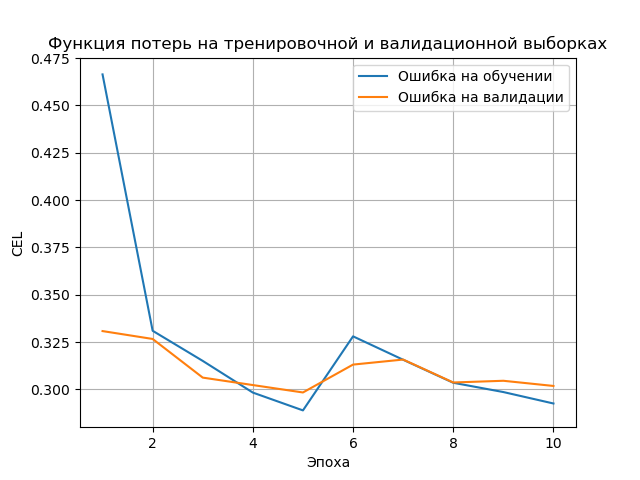

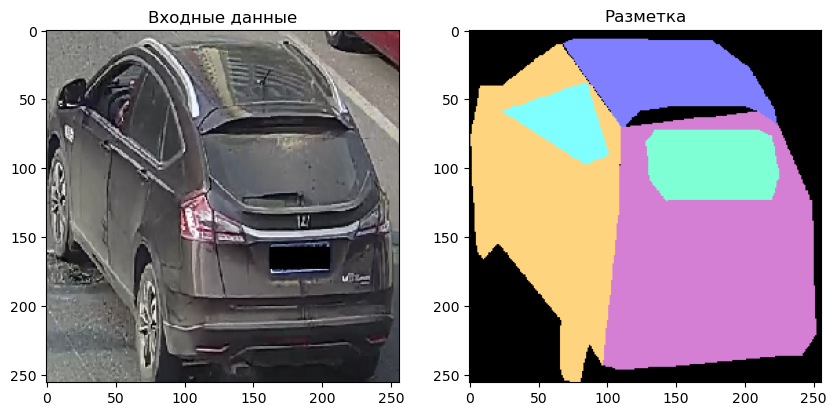

In [125]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

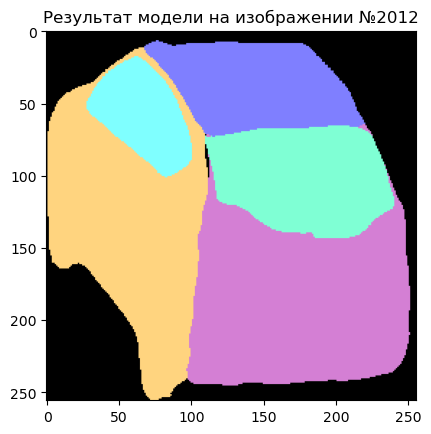

In [126]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Модель, как было сказано выше не успела переобучиться. Можно заметить, что модель на изображении слишком сильно растянула вниз окно, однако правильно определила, что козырек не является фоном, следовательно, справилась с этим лучше разметки. Так же хотел бы обратить внимание на левое стекло. Оно более правдиво отражает реальную ситацию. Плюс данная модель имеет наилучшие метрики качества.

In [127]:
# Модель 3
model = smp.UnetPlusPlus(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_unet_plus_plus_3.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.358917, DICE = 0.881834, Jaccard_Index = 0.757866


<h1><center>Модель Unet++ 3</center></h1>

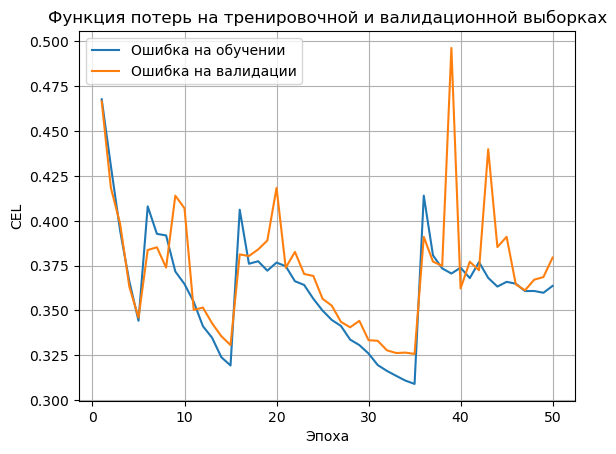

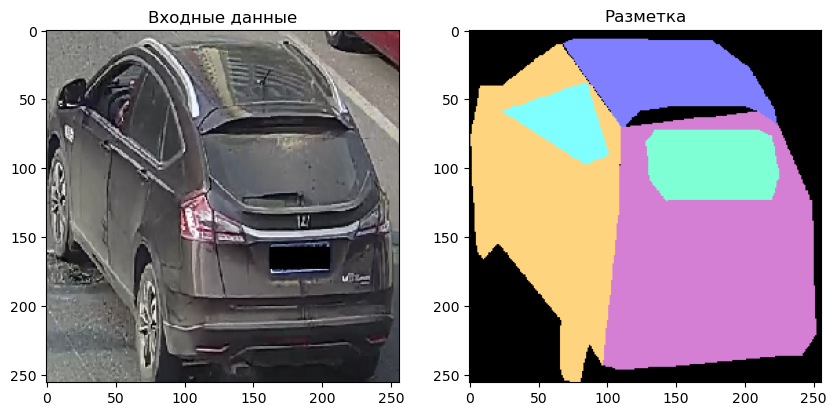

In [128]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

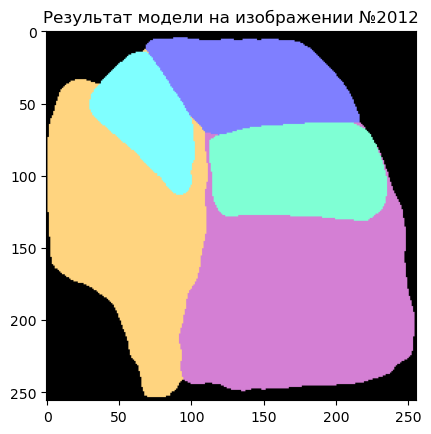

In [129]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Как было указано выше, модель недообучилась. По метрикам она уступает предудыщим моделям. По рисунку можно казать, что модель пока еще плохо определяет форму машины. Безусловно, разделить детали можно, но границы получаются размытыми.

# 5.2 Модель DeepLabV3

In [133]:
# Модель 1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model = smp.DeepLabV3(classes=10)
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_deep_labv3_1.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.539418, DICE = 0.838398, Jaccard_Index = 0.644563


<h1><center>Модель DeepLabV3_1</center></h1>

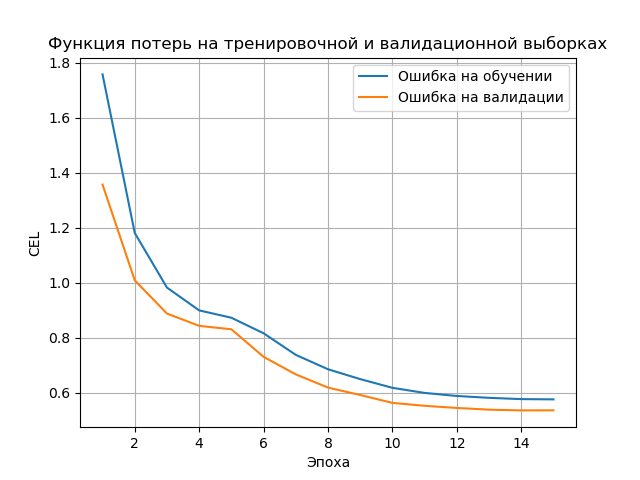

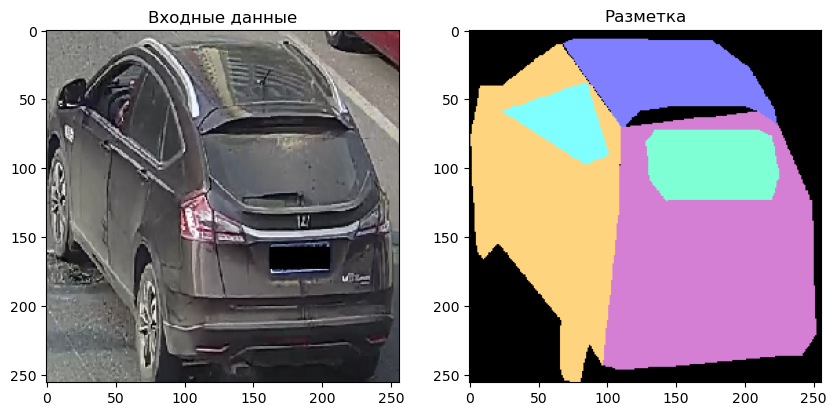

In [134]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

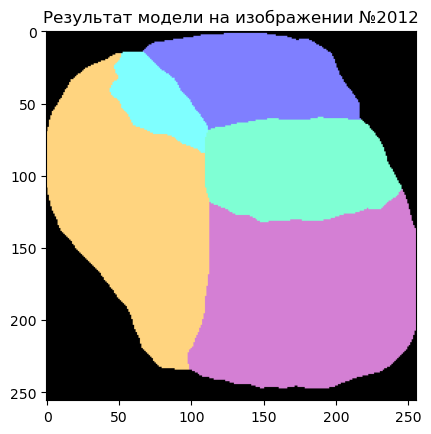

In [135]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Модель недообучилась. Изображение не напоминает машину. Правильно размечены лишь области, где может находиться определенная деталь. На недообучение указывают и низкие показатели качества.

In [136]:
# Модель 2
model = smp.DeepLabV3(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_deep_labv3_2.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.319911, DICE = 0.893987, Jaccard_Index = 0.776962


<h1><center>Модель DeepLabV3_2</center></h1>

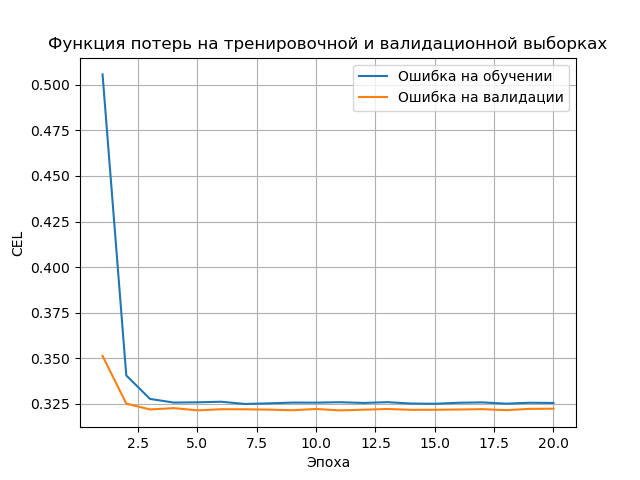

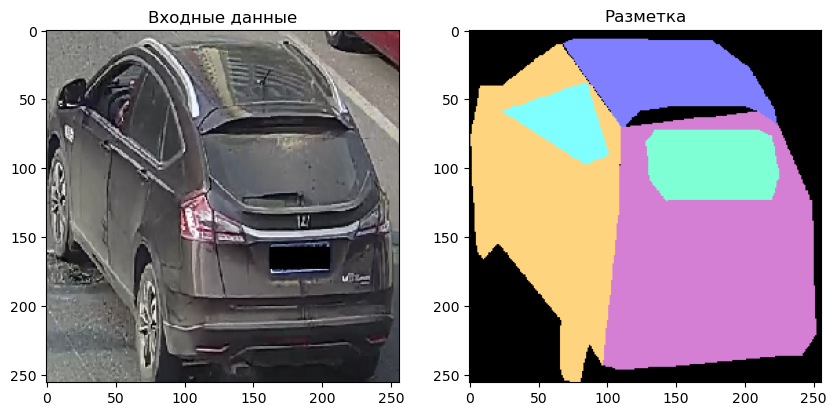

In [137]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

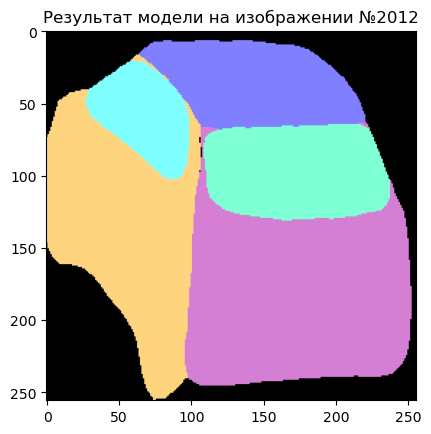

In [138]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Из графика и метрик качества видно, что модель является хорошей. Не так сильно уступает Unet++ 2. Изображение, получаемое на выходе из модели похоже на результат работы модели Unet++ 2, модель не повторила ошибку разметки.

In [139]:
# Модель 3
model = smp.DeepLabV3(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_deep_labv3_3.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.543742, DICE = 0.868735, Jaccard_Index = 0.734088


<h1><center>Модель DeepLabV3_3</center></h1>

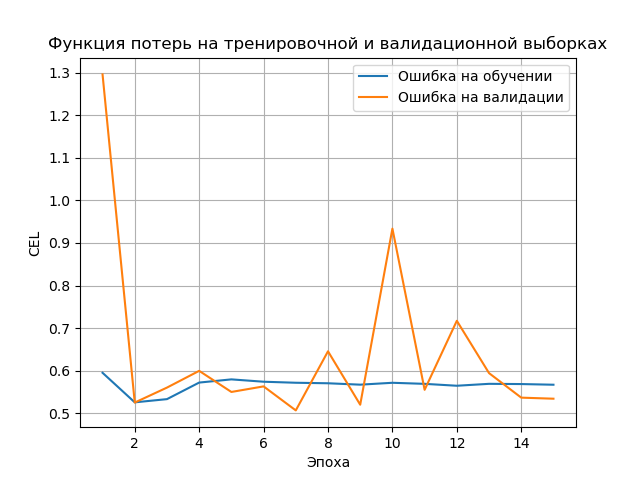

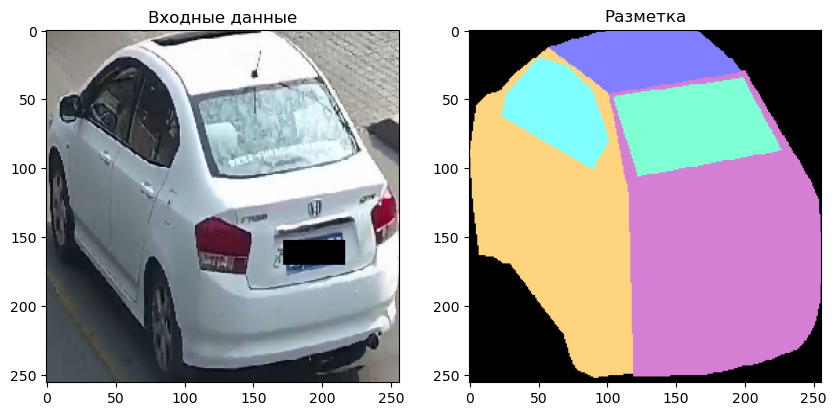

In [140]:
idx = 877
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

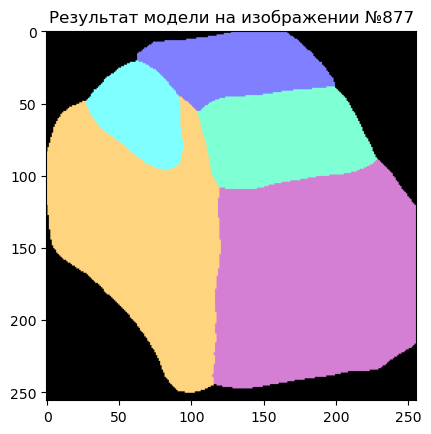

In [141]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Модель недообучилась. Из рисунка видно, что форма не соблюдена. Хотя бы совпадают цвета.

# 5.3 Модель PAN

In [57]:
# Модель 1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model =  smp.PAN(classes=10)
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PAN_1.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.391877, DICE = 0.869073, Jaccard_Index = 0.733433


<h1><center>Модель PAN_1</center></h1>

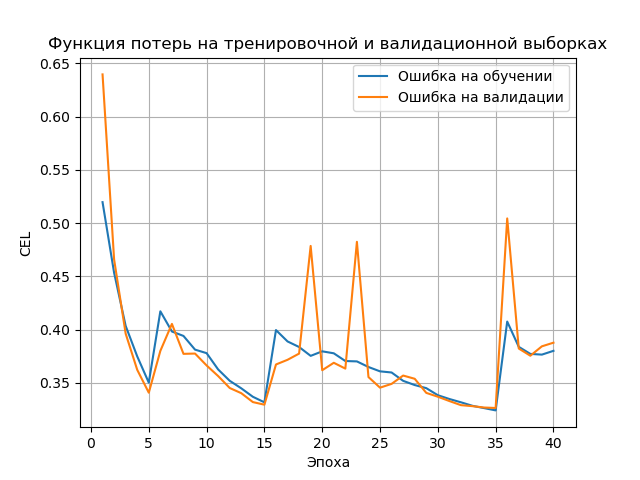

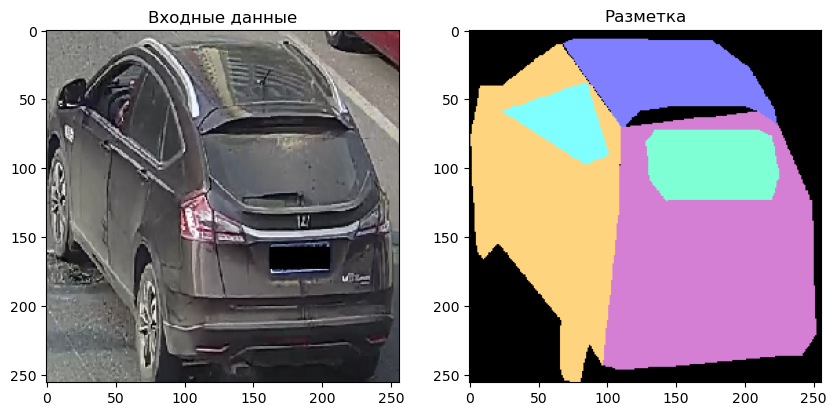

In [55]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

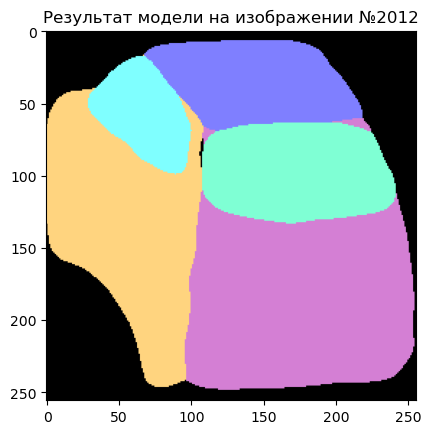

In [56]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: модель является чересчур гладкой (границы очень гладкие), поэтому форма передана плохо. Модель пока не сильно переобучилась. Однако несмотря на высокие показатели качества, использовать ее нельзя.

In [145]:
# Модель 2
model = smp.PAN(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PAN_2.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.335286, DICE = 0.887847, Jaccard_Index = 0.764341


<h1><center>Модель PAN_2</center></h1>

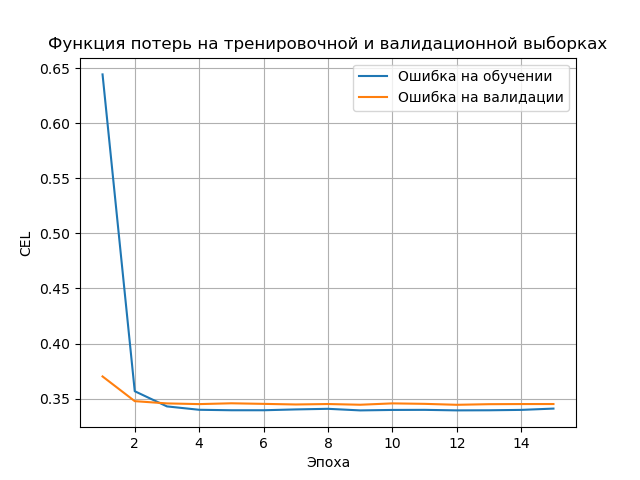

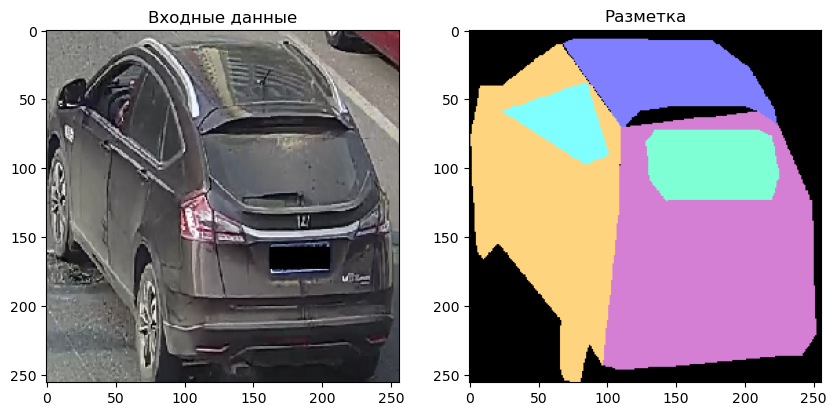

In [146]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

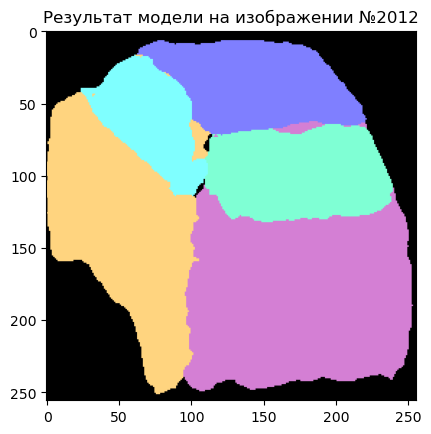

In [147]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__:У модели низкие показатели качества, хотя она уже вышла по плато на кривых обучения. Изображение, полученной данной модлью получилось со многими пересечениями классов, отсуствуют границы. Такой результат не может быть признан качественным.

In [148]:
# Модель 3
model = smp.PAN(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PAN_3.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.356351, DICE = 0.895033, Jaccard_Index = 0.780652


<h1><center>Модель PAN_3</center></h1>

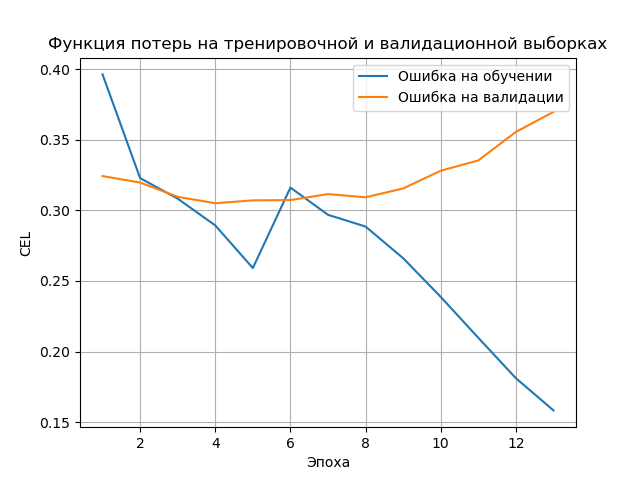

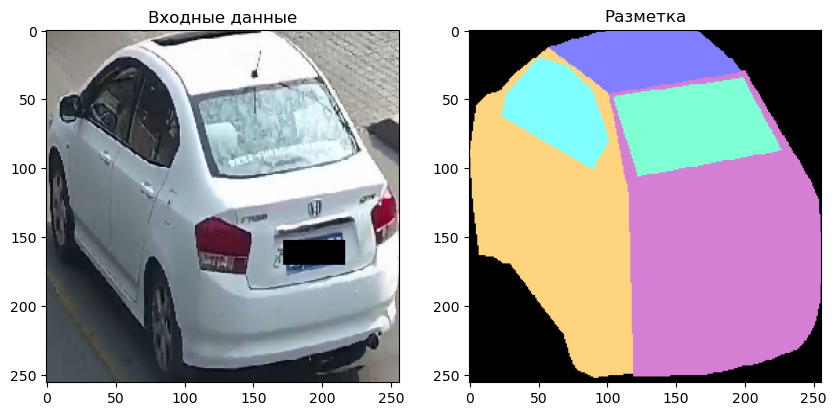

In [149]:
idx = 877
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

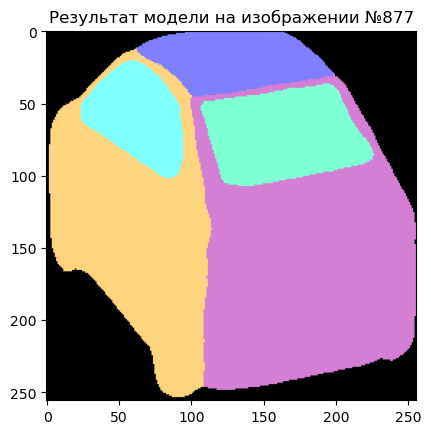

In [150]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Несмотря на то, что модель переобучилась, она показывает как хорошие показатели численные, так и можно заметить по изображению. Границы есть, края сглажены хорошо, явных ошибок классификации пикселей не наблюдается. Такую модель нельяз дообучить, но вполне она пригодна к использованию.

# 5.4 Модель PSPNet

In [151]:
# Модель 1
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
criterion = nn.CrossEntropyLoss()
model =  smp.PSPNet(classes=10)
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PSPNet_1.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.298458, DICE = 0.899185, Jaccard_Index = 0.786704


<h1><center>Модель PSPNet_1</center></h1>

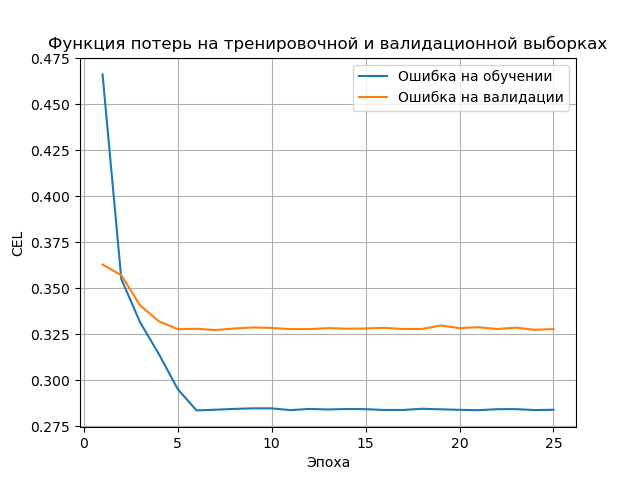

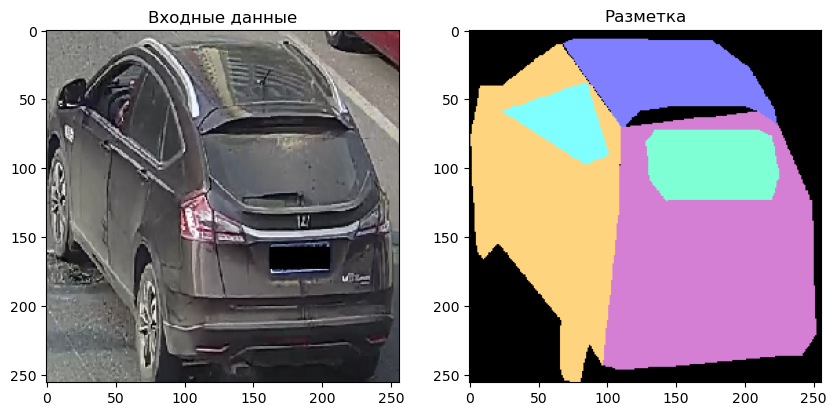

In [152]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

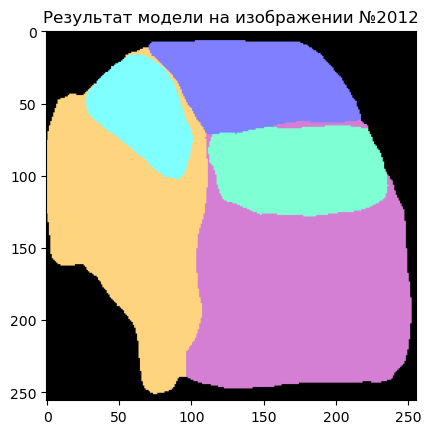

In [153]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__:Можно попробовать дообучить эту модель на большем числе эпох, так как PSPNet обучается относительно быстро.

In [154]:
# Модель 2
model = smp.PSPNet(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PSPNet_2.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 0.349869, DICE = 0.895115, Jaccard_Index = 0.782107


<h1><center>Модель PSPNet_2</center></h1>

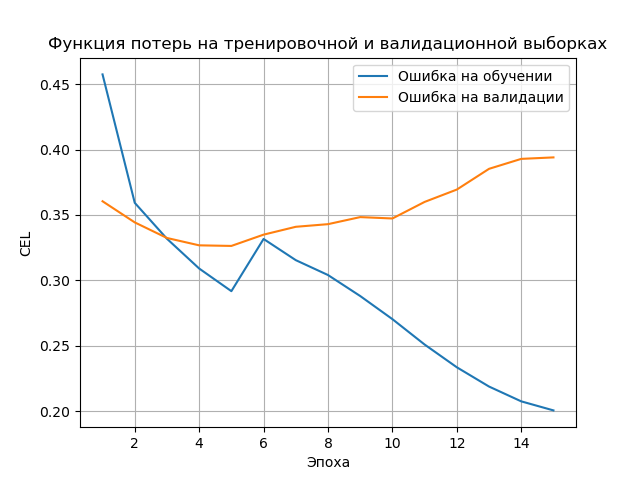

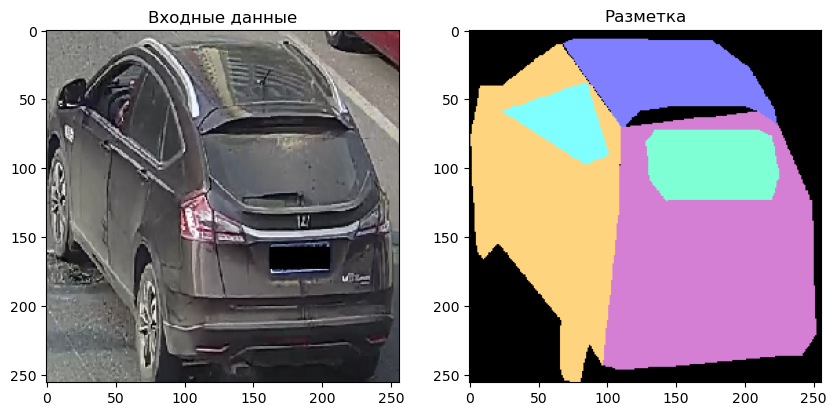

In [155]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

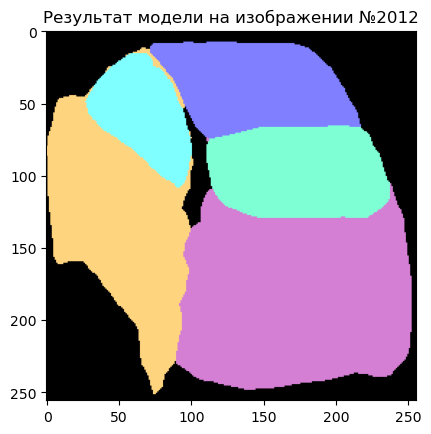

In [156]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: На рисунке видно, что модель неправильно классифицировала фон, колеса. Такая модель не является пригодной к использованию.

In [157]:
# Модель 3
model = smp.PSPNet(classes=10)
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PSPNet_3.pth", map_location=torch.device("cuda:0")))
model.eval()
model.to(DEVICE)
loss, dic, jacc = test(model=model, loader=test_loader, loss_function=criterion)
print(f"Test Loss = {loss:.6}, DICE = {dic:.6}, Jaccard_Index = {jacc:.6}")

0it [00:00, ?it/s]

Test Loss = 402.781, DICE = 0.225783, Jaccard_Index = 0.0230591


<h1><center>Модель PSPNet_3</center></h1>

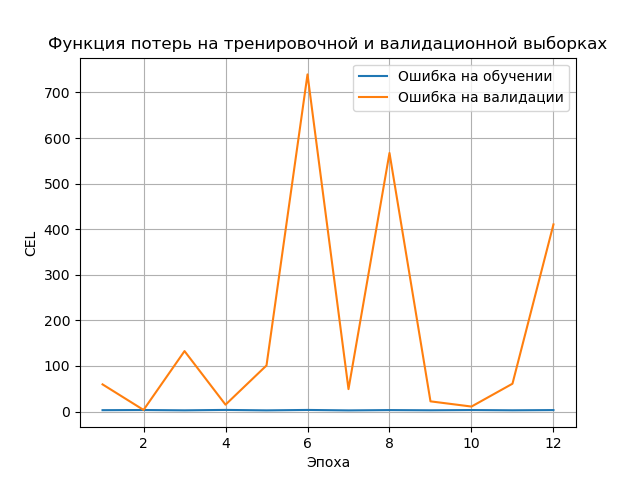

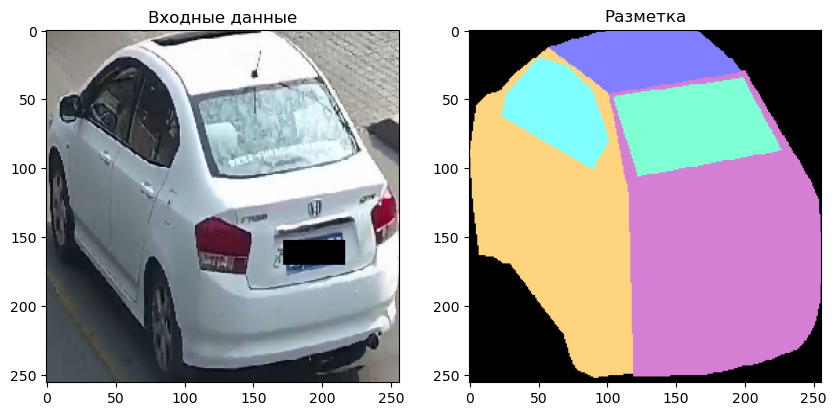

In [158]:
idx = 877
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
model.eval()
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

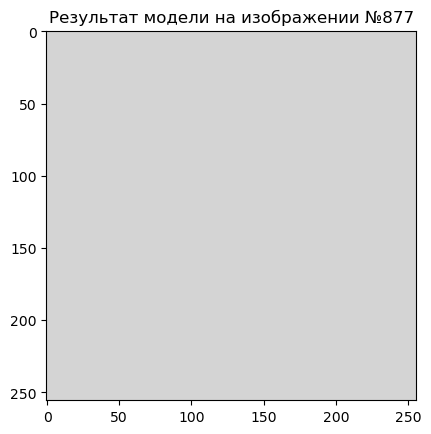

In [159]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Модель выдает 1 цвет. 

# 6. Обработка результатов

In [28]:
models = pd.read_csv("models_scores.csv") # загрузим csv файл с моделями
models["Time"] = models["Time"] / 3600 # приведем время к часам
models.rename(columns={"Time":"Time, hours"}, inplace=True)
models.sort_values(by=["Dice", "Jaccard"], ascending=False) # отсортируем по метрикам качества

model_name  num_epochs        loss      Dice   Jaccard  \
1   model_unet_plus_plus_2          10    0.295650  0.900077  0.790379   
9           model_PSPNet_1          25    0.298458  0.899185  0.786704   
2   model_unet_plus_plus_1          12    0.338221  0.896091  0.786885   
10          model_PSPNet_2          15    0.349869  0.895115  0.782107   
8              model_PAN_3          13    0.356351  0.895033  0.780652   
4       model_deep_labv3_2          20    0.319911  0.893987  0.776962   
6              model_PAN_2          15    0.335286  0.887847  0.764341   
0   model_unet_plus_plus_3          50    0.358917  0.881834  0.757866   
7              model_PAN_1          40    0.391877  0.869073  0.733433   
5       model_deep_labv3_3          15    0.543742  0.868735  0.734088   
3       model_deep_labv3_1          15    0.539418  0.838398  0.644563   
11          model_PSPNet_3          12  402.781086  0.225783  0.023059   

    Time, hours  
1      2.681030  
9      3.077972  
2      2.787864  
10     1.867672  
8      2.012186  
4      4.350117  
6      2.395780  
0     12.765842  
7      6.185543  
5      3.845722  
3      3.480622  
11     1.479076

Лучшими моделями оказались: 
* model_unet_plus_plus_2	
* model_PSPNet_1	
* model_unet_plus_plus_1

Однако мы  можем улучшить качество этих моделей. Для этого проведем анализ по графикам функции ошибки по эпохам на тренировочной и валидационной выборках. Найдем модели, которые не успели переобучиться.
Из графиков видно, что оказались непереобученными (или не так сильно переобучились) и показали относительно высокую эффективность следующие модели:
* model_unet_plus_plus_2
* model_PSPNet_1 (с большой долей условности)
* model_deep_labv3_2

Для удобства сравнения будем называть их первая, вторая и третья модели соответсвенно. Видно, что метрика Dice выше всего у первой модели, как впрочем и материка Жаккарда. Результат модели 1 практически на 80% перекрывает объединение результата модели и разметку. Однако разница в показателях для выбранных моделей является незначительной. Стоит так же заметить, что некоторая разметка куда хуже соотвествует реальному положению, чем результат наших моделей. Безусловно, стоит учитывать этот фактор при формулировании выводов на основе метрик качества. Сравнивать с ответами, где есть неправльные,- подход, формально снижающий качество модели.

Плюс первой модели заключается в том, что она обучалась всего 10 эпох, что составило чуть больше 2.5 часов, в то время как обучение других моделей дольше. Однако вторая модель за 3 часа прошла 25 эпох. Это связано с тем, что он не такая большая. Руководствуюясь данными предположениями попробуем дообучить имеющиеся модели с _early-stopping_ (остановка обучения модели, если метрика на валидации начинает расти). Затем проведем окончательный анализ.

# 7 Дообучение обучение моделей

In [53]:
# модель model_unet_plus_plus_2
model = smp.UnetPlusPlus(classes=10) # модель
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_unet_plus_plus_2.pth", map_location=torch.device("cuda:0")))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 10 # Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер
model.to(DEVICE) # перевод модели на GPU

start_time = time.time()
train_losses = [] # список потерь на обучении
val_losses = [] # список потерь на валидаци

val_pred = 100000
for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе
    # обучение
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    # валидация
    val_loss, DICE, JACCARD = test(model=model, loader=valid_loader, loss_function=criterion)

    train_losses.append(train_loss) # сохраняем ошибку на обучени
    val_losses.append(val_loss) # сохраняем ошибку на валидации
    # вывод номера эпохи, ошибки и метрик качества
    print(f'Epoch {epoch + 11}')
    print(f'Train Loss {train_loss:.6f} Val loss {val_loss:.6f} Dice {DICE:.6f} JaccardIndex {JACCARD:.6f}')
    print('---')
    if val_loss > val_pred:
        print(f"Обучение остановлено")
        n_epochs1 = epoch
        break
    else:
        val_pred = val_loss


end_time = time.time() - start_time # время окончания обучения

  0%|          | 0/10 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 11
Train Loss 0.300343 Val loss 0.296308 Dice 0.904022 JaccardIndex 0.799852
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 12
Train Loss 0.295546 Val loss 0.294865 Dice 0.904733 JaccardIndex 0.801373
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 13
Train Loss 0.284063 Val loss 0.290818 Dice 0.906451 JaccardIndex 0.804503
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 14
Train Loss 0.273489 Val loss 0.289732 Dice 0.906443 JaccardIndex 0.805178
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 15
Train Loss 0.261109 Val loss 0.290894 Dice 0.906645 JaccardIndex 0.805340
---
Обучение остановлено


Таким образом, оптимальное число эпох: 15

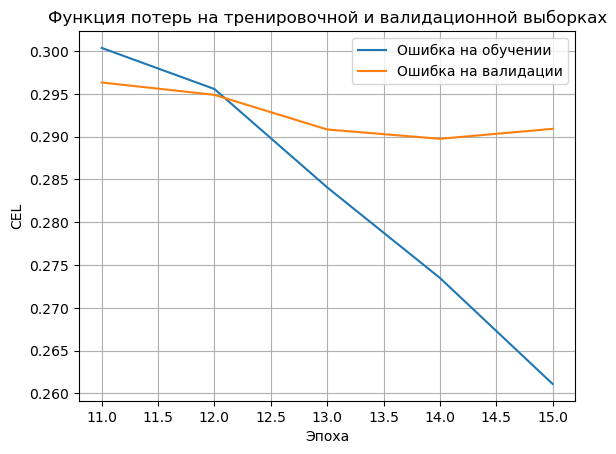

In [54]:
# Вывод графика
fig, ax = plt.subplots()
ax.set_title("Функция потерь на тренировочной и валидационной выборках")
ax.plot(range(11, n_epochs1 + 12), np.array(train_losses), label = 'Ошибка на обучении')
ax.plot(range(11, n_epochs1 + 12), np.array(val_losses), label = 'Ошибка на валидации')
ax.legend()
ax.grid()
ax.set(xlabel = 'Эпоха', ylabel = 'CEL')
plt.show()
fig.savefig('SEGMENTATION_MODELS/model_unet_plus_plus_2_upd.png') # сохранение графика

In [13]:
# дообучение
model = smp.UnetPlusPlus(classes=10) # модель
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_unet_plus_plus_2.pth", map_location=torch.device("cuda:0")))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = n_epochs1 # Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate) # оптимайзер
scheduler = torch.optim.lr_scheduler.CosineAnnealingWarmRestarts(optimizer, T_0=5, T_mult=2, eta_min=1e-6) # шедулер
model.to(DEVICE) # перевод модели на GPU

start_time = time.time()

for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе
    # обучение
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)

end_time1 = time.time() - start_time # время окончания обучения

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [14]:
loss1, dic1, jacc1 = test(model=model, loader=test_loader, loss_function=criterion) # тестирование на отложенной выборке
print(f"loss: {loss1:.6} DICE {dic1:.6} Jaccard {jacc1:.6}")

0it [00:00, ?it/s]

loss: 0.279396 DICE 0.906449 Jaccard 0.805233


Метрики качества хоть и незначительно, но улучшились.

In [15]:
torch.save(model.state_dict(), r"SEGMENTATION_MODELS/model_unet_plus_plus_2_upd.pth") # сохранение модели

In [16]:
# модель model_deep_labv3_2
model = smp.DeepLabV3(classes=10) # модель
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_deep_labv3_2.pth", map_location=torch.device("cuda:0")))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 100 # Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [i for i in range(num_epochs)]) # шедулер
model.to(DEVICE) # перевод модели на GPU
start_time = time.time()
train_losses = [] # список потерь на обучении
val_losses = [] # список потерь на валидаци

val_pred = 100000
for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе
    # обучение
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    # валидация
    val_loss, DICE, JACCARD = test(model=model, loader=valid_loader, loss_function=criterion)

    train_losses.append(train_loss) # сохраняем ошибку на обучени
    val_losses.append(val_loss) # сохраняем ошибку на валидации
    # вывод номера эпохи, ошибки и метрик качества
    print(f'Epoch {epoch + 21}')
    print(f'Train Loss {train_loss:.6f} Val loss {val_loss:.6f} Dice {DICE:.6f} JaccardIndex {JACCARD:.6f}')
    print('---')
    if val_loss > val_pred:
        print(f"Обучение остановлено")
        n_epochs2 = epoch
        break
    else:
        val_pred = val_loss


end_time = time.time() - start_time # время окончания обучения

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 21
Train Loss 0.353414 Val loss 0.329932 Dice 0.893335 JaccardIndex 0.778922
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 22
Train Loss 0.315177 Val loss 0.312863 Dice 0.898927 JaccardIndex 0.789471
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 23
Train Loss 0.307414 Val loss 0.310590 Dice 0.899975 JaccardIndex 0.791265
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 24
Train Loss 0.305626 Val loss 0.310389 Dice 0.899911 JaccardIndex 0.791286
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 25
Train Loss 0.305913 Val loss 0.310458 Dice 0.899858 JaccardIndex 0.791413
---
Обучение остановлено


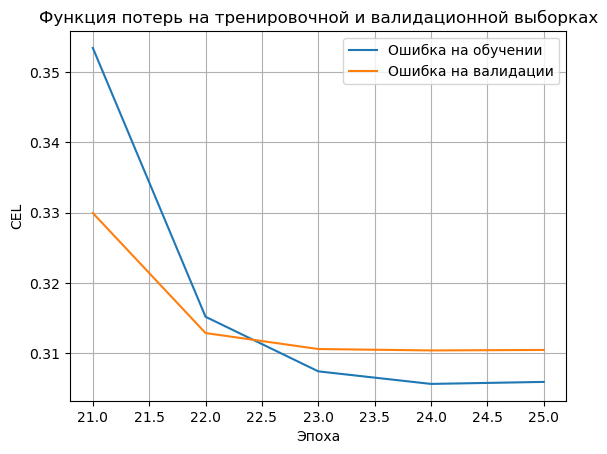

In [17]:
# Вывод графика
fig, ax = plt.subplots()
ax.set_title("Функция потерь на тренировочной и валидационной выборках")
ax.plot(range(21, n_epochs2 + 22), np.array(train_losses), label = 'Ошибка на обучении')
ax.plot(range(21, n_epochs2 + 22), np.array(val_losses), label = 'Ошибка на валидации')
ax.legend()
ax.grid()
ax.set(xlabel = 'Эпоха', ylabel = 'CEL')
plt.show()
fig.savefig('SEGMENTATION_MODELS/model_deep_labv3_2_upd.png') # сохранение графика

Оптимальное число эпох: 24

In [18]:
# модель model_deep_labv3_2
model = smp.DeepLabV3(classes=10) # модель
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_deep_labv3_2.pth", map_location=torch.device("cuda:0")))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = n_epochs2 # Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.Adam(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.MultiStepLR(optimizer, [i for i in range(num_epochs)]) # шедулер
model.to(DEVICE) # перевод модели на GPU
start_time = time.time()

val_pred = 100000
for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе
    # обучение
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)

end_time2 = time.time() - start_time # время окончания обучения

  0%|          | 0/4 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [19]:
loss2, dic2, jacc2 = test(model=model, loader=test_loader, loss_function=criterion) # тестирование на отложенной выборке
print(f"loss: {loss2:.6} DICE {dic2:.6} Jaccard {jacc2:.6}")

0it [00:00, ?it/s]

loss: 0.29783 DICE 0.899361 Jaccard 0.789015


In [20]:
torch.save(model.state_dict(), r"SEGMENTATION_MODELS/model_deep_labv3_2_upd.pth") # сохранение модели

In [21]:
# модель model_PSPNet_1
model = smp.PSPNet(classes=10) # модель
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PSPNet_1.pth", map_location=torch.device("cuda:0")))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = 100 # Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer) # шедулер
model.to(DEVICE) # перевод модели на GPU

start_time = time.time()
train_losses = [] # список потерь на обучении
val_losses = [] # список потерь на валидаци

val_pred = 100000
for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе
    # обучение
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)
    # валидация
    val_loss, DICE, JACCARD = test(model=model, loader=valid_loader, loss_function=criterion)

    train_losses.append(train_loss) # сохраняем ошибку на обучени
    val_losses.append(val_loss) # сохраняем ошибку на валидации
    # вывод номера эпохи, ошибки и метрик качества
    print(f'Epoch {epoch + 26}')
    print(f'Train Loss {train_loss:.6f} Val loss {val_loss:.6f} Dice {DICE:.6f} JaccardIndex {JACCARD:.6f}')
    print('---')
    if val_loss > val_pred:
        print(f"Обучение остановлено")
        n_epochs3 = epoch
        break
    else:
        val_pred = val_loss


end_time = time.time() - start_time # время окончания обучения

  0%|          | 0/100 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 26
Train Loss 0.332410 Val loss 0.321829 Dice 0.895123 JaccardIndex 0.782835
---


  0%|          | 0/1200 [00:00<?, ?it/s]

0it [00:00, ?it/s]

Epoch 27
Train Loss 0.313117 Val loss 0.322175 Dice 0.894427 JaccardIndex 0.782789
---
Обучение остановлено


Модель уже была переобученной, дообучение не привело ни к каким результатам.

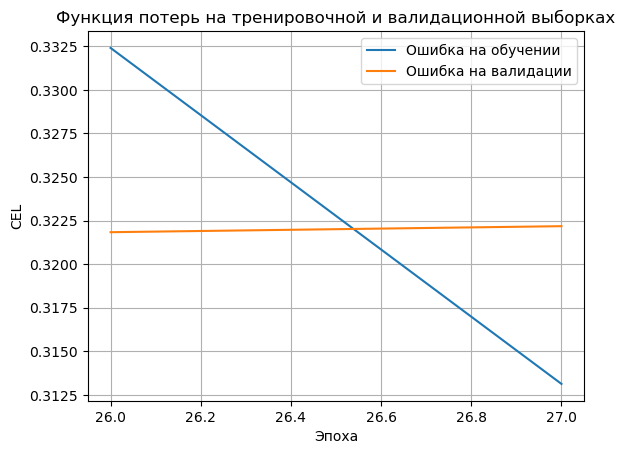

In [22]:
fig, ax = plt.subplots()
ax.set_title("Функция потерь на тренировочной и валидационной выборках")
ax.plot(range(26, n_epochs3 + 27), np.array(train_losses), label = 'Ошибка на обучении')
ax.plot(range(26, n_epochs3 + 27), np.array(val_losses), label = 'Ошибка на валидации')
ax.legend()
ax.grid()
ax.set(xlabel = 'Эпоха', ylabel = 'CEL')
plt.show()
fig.savefig('SEGMENTATION_MODELS/model_PSPNet_1_upd.png') # сохранение графика

In [24]:
# дообучение
model = smp.PSPNet(classes=10) # модель
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_PSPNet_1.pth", map_location=torch.device("cuda:0")))
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
num_epochs = n_epochs3# Число эпох
learning_rate = 3 * 10**(-4) # скорость обучения
criterion = nn.CrossEntropyLoss() # функция потерь
optimizer = torch.optim.AdamW(model.parameters(), lr = learning_rate, weight_decay=0.02) # оптимайзер
scheduler = torch.optim.lr_scheduler.PolynomialLR(optimizer) # шедулер
model.to(DEVICE) # перевод модели на GPU

start_time = time.time()


val_pred = 100000
for epoch in tqdm(range(num_epochs)): # проход по каждой эпохе
    # обучение
    train_loss = train(model, loader=train_loader, loss_function=criterion, optimizer=optimizer, scheduler=scheduler)

    


end_time3 = time.time() - start_time # время окончания обучения

  0%|          | 0/1 [00:00<?, ?it/s]

  0%|          | 0/1200 [00:00<?, ?it/s]

In [25]:
loss3, dic3, jacc3 = test(model=model, loader=test_loader, loss_function=criterion) # тестирование на отложенной выборке
print(f"loss: {loss3:.6} DICE {dic3:.6} Jaccard {jacc3:.6}")

0it [00:00, ?it/s]

loss: 0.323597 DICE 0.89061 Jaccard 0.773924


In [26]:
torch.save(model.state_dict(), r"SEGMENTATION_MODELS/model_PSPNet_1_upd.pth") # сохранение модели

In [58]:
#  обновляем показатели моделей
models.iloc[1, 1:] = np.array([models.loc[1, 'num_epochs'] + n_epochs1, loss1, dic1, jacc1, models.loc[1, 'Time, hours'] + end_time1/3600])
models.iloc[4, 1:] = np.array([models.loc[4, 'num_epochs'] + n_epochs2, loss2, dic2, jacc2, models.loc[4, 'Time, hours'] + end_time2/3600])
models.iloc[9, 1:] = np.array([models.loc[9, 'num_epochs'] + n_epochs3, loss3, dic3, jacc3, models.loc[9, 'Time, hours'] + end_time3/3600])

In [59]:
models.to_csv('result_models.csv', index=False) # сохраняем результаты в csv-файл

Дальнейшее обучение не несет никакого смысла, так как мы воспользовались _early-stoping_

# 8 Выводы

In [69]:
models = pd.read_csv("result_models.csv")
models.sort_values(by=["Dice", "Jaccard"], ascending=False)

model_name  num_epochs        loss      Dice   Jaccard  \
1   model_unet_plus_plus_2          14    0.279396  0.906449  0.805233   
4       model_deep_labv3_2          24    0.297830  0.899361  0.789015   
2   model_unet_plus_plus_1          12    0.338221  0.896091  0.786885   
10          model_PSPNet_2          15    0.349869  0.895115  0.782107   
8              model_PAN_3          13    0.356351  0.895033  0.780652   
9           model_PSPNet_1          26    0.323597  0.890610  0.773924   
6              model_PAN_2          15    0.335286  0.887847  0.764341   
0   model_unet_plus_plus_3          50    0.358917  0.881834  0.757866   
7              model_PAN_1          40    0.391877  0.869073  0.733433   
5       model_deep_labv3_3          15    0.543742  0.868735  0.734088   
3       model_deep_labv3_1          15    0.539418  0.838398  0.644563   
11          model_PSPNet_3          12  402.781086  0.225783  0.023059   

    Time, hours  
1      3.526295  
4      4.938539  
2      2.787864  
10     1.867672  
8      2.012186  
9      3.153814  
6      2.395780  
0     12.765842  
7      6.185543  
5      3.845722  
3      3.480622  
11     1.479076

Таким образом, лучшими моделями с практически одинаковыми показателями Dice, являются `model_unet_plus_plus_2` и `model_deep_labv3_2`. Однако у второй модели хуже метрика Жаккарда, вдобавок она обучалась дольше практически на полтора часа. Таким образом, лучшей моделью оказалась модель __Unet++__, разработанная для решения задач в медицине, но хорошо показавшая себя в сегментации деталей автомобиля. Индекс Dice, равный 0.9 является хорошим резльтатом, следовательно  количество правильно предсказанных пикселей, деленной на число правильных, ошибок первого и второго рода, равно 90%. На представленных ниже фотографиях видно, что модель работает хорошо, как с данными изи датасета, так и с картинками из интернета.  Также ниже приведу примеры работы нейросети.

In [73]:
print(f"Общее время обучения: {models['Time, hours'].sum():.5} часов.")

Общее время обучения: 48.439 часов.


In [74]:
model = smp.UnetPlusPlus(classes=10) # модель
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu") # поиск GPU
# Загрузка весов
model.load_state_dict(torch.load("SEGMENTATION_MODELS/model_unet_plus_plus_2_upd.pth", map_location=torch.device("cuda:0")))
model.eval() # перевод модели в режим работы
model.to(DEVICE);

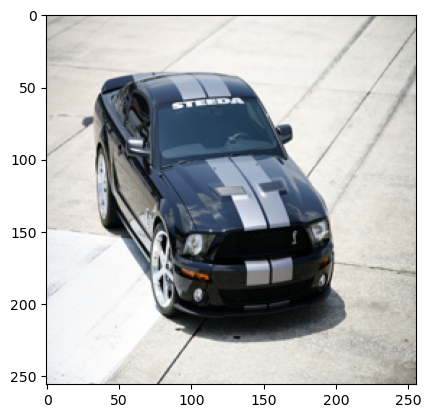

In [76]:
img = Image.open('mustang-shelbi-gt500-polosy-chernyj.jpg')
img = img.resize((256, 256))
x1 = transforms.ToTensor()(img)
plt.imshow(x1.permute(1, 2, 0))

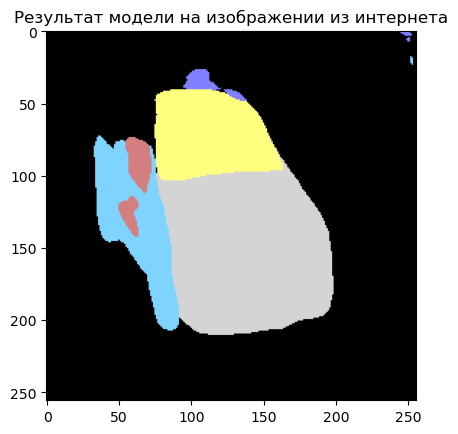

In [77]:
res = model(x1.unsqueeze(0).to(DEVICE))
plt.title("Результат модели на изображении из интернета")
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Много ошибок, хорошо выделены только лобовое стекло и передняя часть машины. Попробуем обрезать фотографию, чтобы привести ее к формату изображений, использованны для обучения.

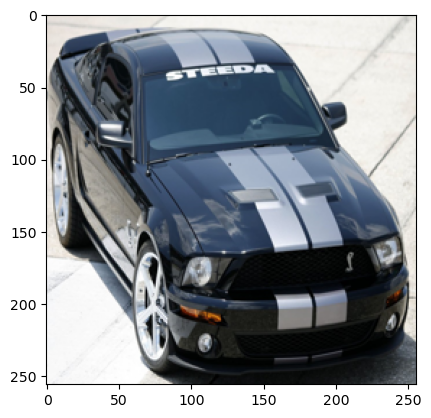

In [79]:
# Случайная картинка из интернета обрезанная
img = Image.open('test_photo.jpg')
img = img.resize((256, 256))
x1 = transforms.ToTensor()(img)
plt.imshow(x1.permute(1, 2, 0))

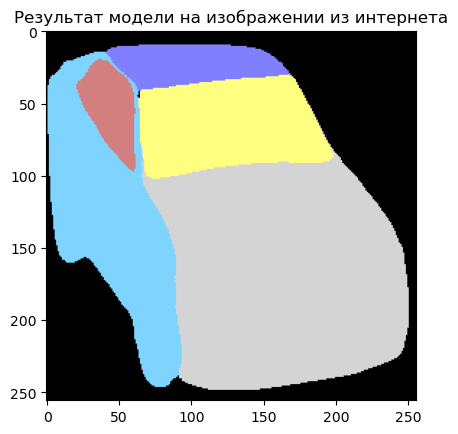

In [82]:
res = model(x1.unsqueeze(0).to(DEVICE))
plt.title("Результат модели на изображении из интернета")
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Видно, что результат намного лучше. Это объясняется тем, что модель обучилась на определенном формате изображений, ей тяжело делать сегментацию тех машин, которые не подходят под формат, например, находятся далеко от камеры.

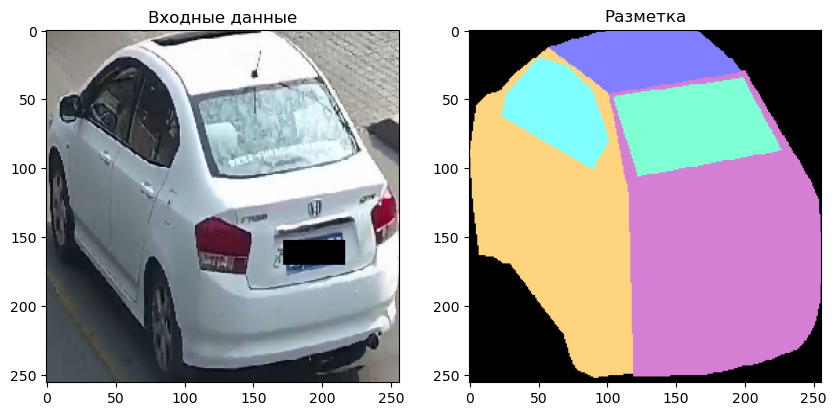

In [72]:
idx = 877
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

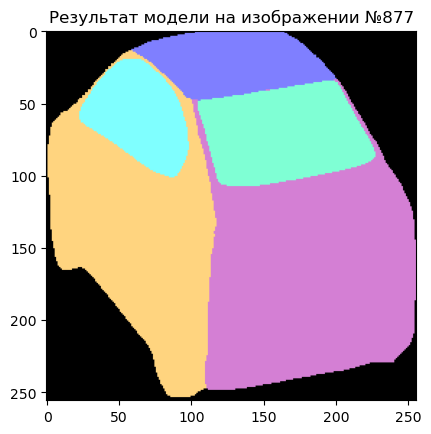

In [73]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Результат на отложенной выборке практически не отличим от разметки

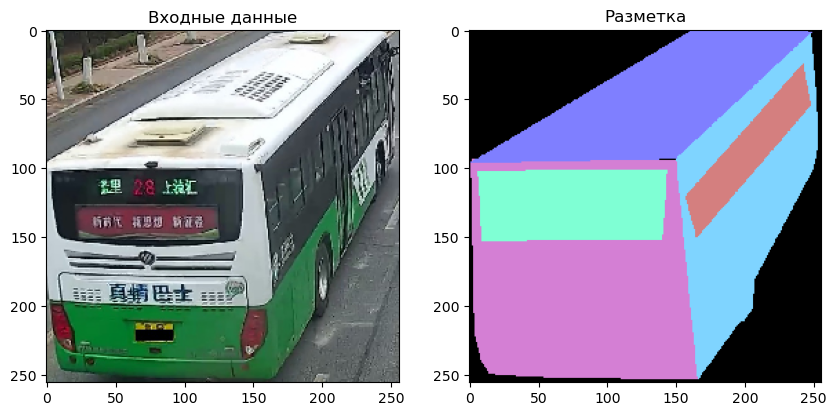

In [74]:
idx = 0
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

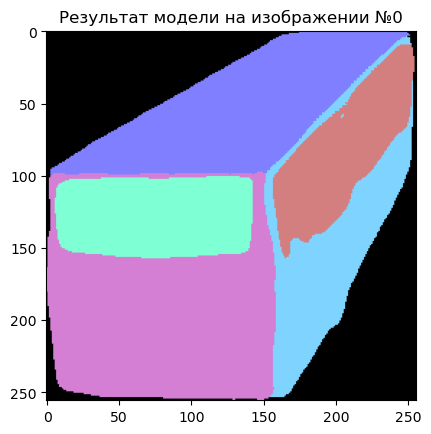

In [75]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Из-за наличия черной пластмассы вокруг окон модель считает все окном.

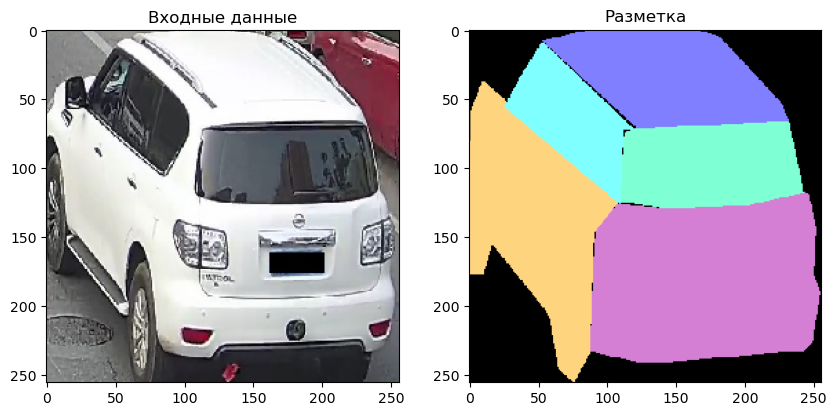

In [76]:
idx = 3000
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

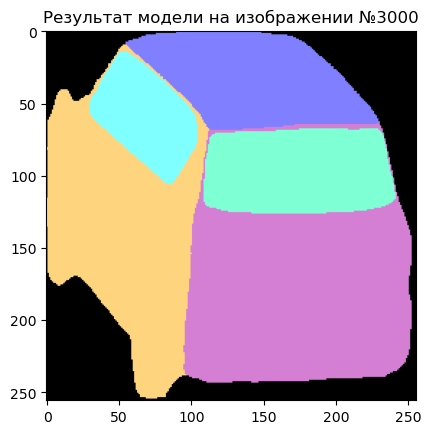

In [77]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Модель показала себя лучше, чем разметка, так как в ней нет черных пикселей фона.

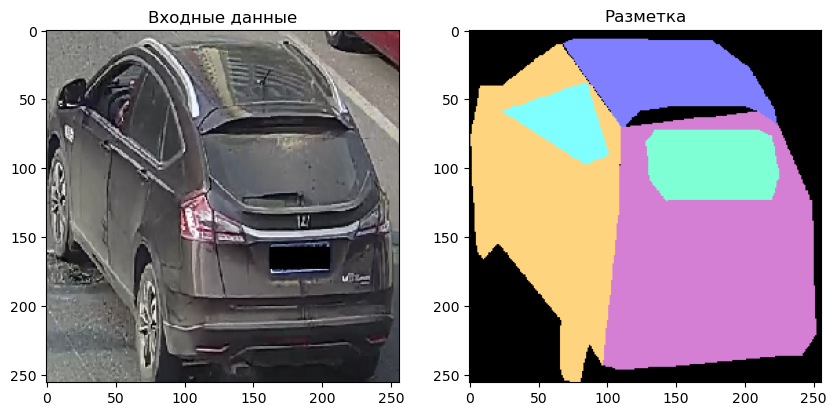

In [78]:
idx = 2012
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

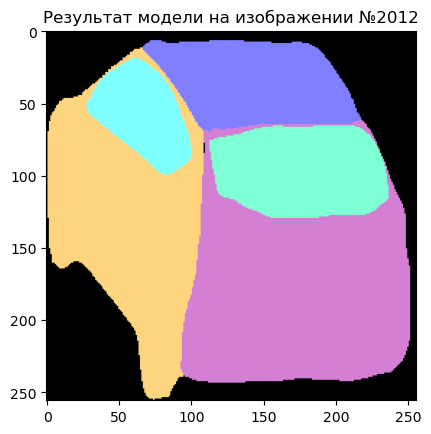

In [79]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

Модель показала себя куда лучше, чем размеченные фотографии (отсутствует черное пятно) и левое стекло имеет более правильную форму

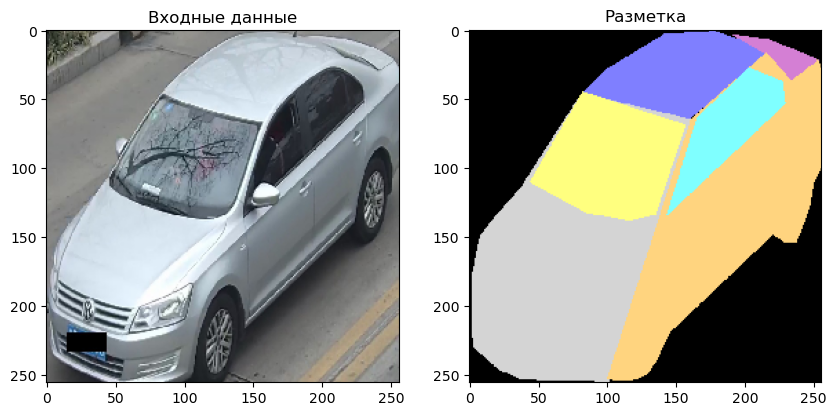

In [88]:
idx = 4
fig, axs = test_dataset.show_img(idx)
axs[0].set_title('Входные данные')
axs[1].set_title('Разметка')
res = model(test_dataset[idx][0].unsqueeze(0).to(DEVICE))

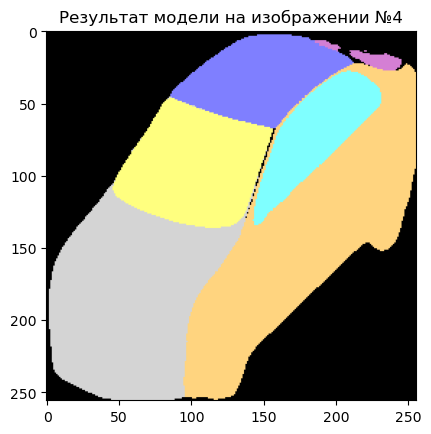

In [89]:
plt.title("Результат модели на изображении №{}".format(idx))
plt.imshow(grayscale_to_RGB(torch.argmax(res, dim=1).detach().cpu()[0]).permute(1,2,0));

__Вывод__: Модель показал себя с одной стороны лучше: капот, с другой хуже: багажник выделен плохо.

__Заключение__:
1. Решена задача, поставленная для курсовой работы: после сравнительного анализа нескольких моделей и механик обучения получилась обученная модель Unet++ с метриками качества: Dice $\approx$ 0.906, Jaccard $\approx$ 0.805.
2. Модель практически идеально проводит сегментацию изображений, которые сняты под определенным ракурсом и занимают большую часть изображения.
3. Модель совершает ошибки, если попадается весьма редкое изображение (например, автобус), но в целом изображение получается читаемым.
4. Модели плохо работает с фотографиями машин, которые сняты в другом формате. Дальше от камеры, больше изображений на фоне. В связи с этим, автором курсовой работы предполагается:
* Разработать и обучить алгоритм машинного обучения, который будет определять местоположение машины на фотографии. Если машин несколько, алгоритм должен это учитывать.
* Затем компьютер должен обрезать исходные фотографии, выделив обнаруженные машины в несколько фотографий.
* Лишь таким способом обработанные изображение могут являться входными данными для модели.
5. При проведенной (пока что вручную) предобработке. Модель выдают хорошие результаты, что видно на изображении форд-мустанг.

# 9 Список использованной литературы
### Интернет-источники
 * <a href="https://hpc-education.unn.ru/files/courses/intel-dl-cv-course-2/Rus/Lectures/Presentations/08_InstanceSegmentation_Rus_pptx.pdf">Сегментация объектов на
изображении с использованием
методов глубокого обучения</a>
* <a href="https://www.kaggle.com/code/nghihuynh/understanding-evaluation-metrics-in-segmentation">Метрики для задач сегментации</a>
* <a href="https://disk.yandex.ru/d/INy3XoMCL3O0rg">Лекции С.В. Макрушина по глубокому обучению, Финансовый Университет</a>
* <a href="https://learnopencv.com/pytorch-for-beginners-semantic-segmentation-using-torchvision/">Описание семантической сегментации в PyTorch</a>
* <a href="https://smp.readthedocs.io/en/latest/index.html">Документация библиотеки segmentation_models_pytorch </a>
* <a href="https://pytorch.org/docs/stable/index.html">Документация библиотеки PyTorch </a>
* <a href="https://habr.com/ru/articles/709276/#1">Статья про Unet++ </a>
* <a href="https://developers.arcgis.com/python/guide/how-deeplabv3-works/">Статья про DeepLabV3 </a>
* <a href="https://arxiv.org/pdf/1406.4729.pdf">Spatial Pyramid Pooling in Deep Convolutional
Networks for Visual Recognition</a>
* <a href="https://medium.com/mlearning-ai/review-pan-pyramid-attention-network-for-semantic-segmentation-semantic-segmentation-8d94101ba24a">Статья про PAN</a>
* <a href="https://arxiv.org/pdf/1805.10180.pdf">Pyramid Attention Network
for Semantic Segmentation</a>
* <a href="https://arxiv.org/abs/1807.10165">A Nested U-Net Architecture for Medical Image Segmentation</a>
* <a href="https://arxiv.org/pdf/1612.01105.pdf">Pyramid Scene Parsing Network</a>


### Видео-ресурсы
* <a href="https://www.youtube.com/watch?v=eycXojn9rcI&t=5s">Использование сверточных сетей для сегментации изображений</a>
* <a href="https://www.youtube.com/watch?v=IHq1t7NxS8k&t=2247s">Пособие по использованию Unet для сегментации изображений</a>
* <a href="https://youtu.be/OWK8VlgJM4I">Сегментация изображений с помощью нейронных сетей</a>
* <a href="https://www.youtube.com/watch?v=q7K78XjJumg&t=885s">Прикладное машинное обучение. Сегментация изображений. МФТИ</a>
* <a href="https://youtube.com/playlist?list=PLoEMreTa9CNm18TPHIYm3t2CLIqxLxzYD">Applied Deep Learning. Maziar Raissi</a>
